# Anticipez les besoins en consommation électrique de bâtiments

## Modèles de prédiction

* [Codage des variables catégorielles](#Codage-des-variables-catégorielles)
* [Mesure de l'importance des variables](#Mesure-de-l'importance-des-variables)
* [Regression Dummy](#Regression-Dummy)
* [Régression linéaire / Linear regression](#Régression-linéaire-/-Linear-regression)
* [Régression Ridge / Ridge regression (Modèle linéaire)](#Régression-Ridge-/-Ridge-regression-(Modèle-linéaire))
* [Régression Ridge à noyau / Kernel Ridge regression ( Modèle non linéaire)](#Régression-Ridge-à-noyau-/-Kernel-Ridge-regression-(-Modèle-non-linéaire))
* [Méthode des k plus proches voisins / k-nearest neighbors algorithm](#Méthode-des-k-plus-proches-voisins-/-k-nearest-neighbors-algorithm)
* [L'algorithme du gradient boosting / Gradient Boosting Regressor](#L'algorithme-du-gradient-boosting-/-Gradient-Boosting-Regressor)
* [Support vector regression (SVR) à noyau linéaire (modèle linéaire)](#Support-vector-regression-(SVR)-à-noyau-linéaire-(modèle-linéaire))
* [Support vector regression (SVR) à noyau rbf (modèle non linéaire)](#Support-vector-regression-(SVR)-à-noyau-rbf (modèle-non-linéaire))
* [Classification](#Classification)
  * [ENERGYSTARScore evaluation](#ENERGYSTARScore-evaluation)


In [465]:
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from missingpy import MissForest
import timeit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

from sklearn import model_selection
from sklearn.experimental import enable_halving_search_cv
from sklearn import dummy
from sklearn import neighbors, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import kernel_ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from matplotlib.pyplot import subplots
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [466]:
data_pred_final = pd.read_csv("Seattle_table.csv",index_col=0)

In [467]:
data_pred_final.head(3)

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ZipCode,TotalGHGEmissions,SiteEnergyUseWN(kBtu),ENERGYSTARScore
0,Hotel,DOWNTOWN,1921-1930,1,12,88434.0,98101,249.43,7097539.0,65.0
1,Hotel,DOWNTOWN,1991-2000,1,11,103566.0,98101,263.51,8765788.0,51.0
2,Hotel,DOWNTOWN,1961-1970,1,41,961990.0,98101,2061.48,75506272.0,18.0


### Codage des variables catégorielles

Notre dataframe contient 2 variables catégorielles non ordinales : `PrimaryPropertyType` et `Neighborhood` et 1 variable ordinale : `YearBuilt`.

Les variables catégorielles vont être codées à l'aide de la librairie `sklearn`. Les variables catégorielles non ordinales vont être codées à l'aide `preprocessing.OneHotEncoder()`tandis que la variable ordinale va être codée avec `preprocessing.LabelEncoder()`

In [468]:
le = LabelEncoder()
ohe = OneHotEncoder(categories='auto')
C1 = ohe.fit_transform(data_pred_final[["PrimaryPropertyType","Neighborhood"]]).toarray()
ohe_columns = ohe.get_feature_names_out(['PrimaryPropertyType', 'Neighborhood']).astype(str)
C1 = pd.DataFrame(C1, columns=[ohe_columns])
C2 = data_pred_final[["YearBuilt"]].apply(le.fit_transform)

In [469]:
data_encod = pd.concat([C1,C2,data_pred_final.drop(["PrimaryPropertyType","Neighborhood","YearBuilt"],axis=1)],axis=1)

In [6]:
data_encod.head(3)

,"(PrimaryPropertyType_Distribution Center,)","(PrimaryPropertyType_Hospital,)","(PrimaryPropertyType_Hotel,)","(PrimaryPropertyType_Laboratory,)","(PrimaryPropertyType_Low-Rise Multifamily,)","(PrimaryPropertyType_Mixed Use Property,)","(PrimaryPropertyType_Office,)","(PrimaryPropertyType_Other,)","(PrimaryPropertyType_Residence Hall/Dormitory,)","(PrimaryPropertyType_Restaurant,)",...,"(Neighborhood_SOUTHEAST,)","(Neighborhood_SOUTHWEST,)",YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ZipCode,TotalGHGEmissions,SiteEnergyUseWN(kBtu),ENERGYSTARScore
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,1,12,88434.0,98101,249.43,7097539.0,65.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9,1,11,103566.0,98101,263.51,8765788.0,51.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6,1,41,961990.0,98101,2061.48,75506272.0,18.0


### Mesure de l'importance des variables

Les forêts aléatoires offrent la possibilité de mesurer l’importance des variables d’entrée sur la prédiction de la variable de sortie. Dans le cas de régression, la mesure de pureté de l’arbre est simplement la somme des carrés des résidus. L'importance d'une variable correspond à la diminution moyenne de l'impureté qu'elle permet.

- Variables importantes dans la prédiction de l'émission de carbone :  

Feature: 0, Score: 0.00012
Feature: 1, Score: 0.42774
Feature: 2, Score: 0.00716
Feature: 3, Score: 0.00332
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00134
Feature: 6, Score: 0.01226
Feature: 7, Score: 0.00617
Feature: 8, Score: 0.00005
Feature: 9, Score: 0.00040
Feature: 10, Score: 0.00056
Feature: 11, Score: 0.00048
Feature: 12, Score: 0.00001
Feature: 13, Score: 0.00183
Feature: 14, Score: 0.00168
Feature: 15, Score: 0.00031
Feature: 16, Score: 0.00005
Feature: 17, Score: 0.00023
Feature: 18, Score: 0.00037
Feature: 19, Score: 0.00013
Feature: 20, Score: 0.00154
Feature: 21, Score: 0.01134
Feature: 22, Score: 0.00118
Feature: 23, Score: 0.00119
Feature: 24, Score: 0.00041
Feature: 25, Score: 0.00009
Feature: 26, Score: 0.00421
Feature: 27, Score: 0.00075
Feature: 28, Score: 0.00065
Feature: 29, Score: 0.00260
Feature: 30, Score: 0.01718
Feature: 31, Score: 0.01650
Feature: 32, Score: 0.04786
Feature: 33, Score: 0.34840
Feature: 34, Score: 0.01739
Feature: 35, Score: 0.06447


Text(0.5, 1.0, 'Les variables importantes pour prédire les émissions de CO2')

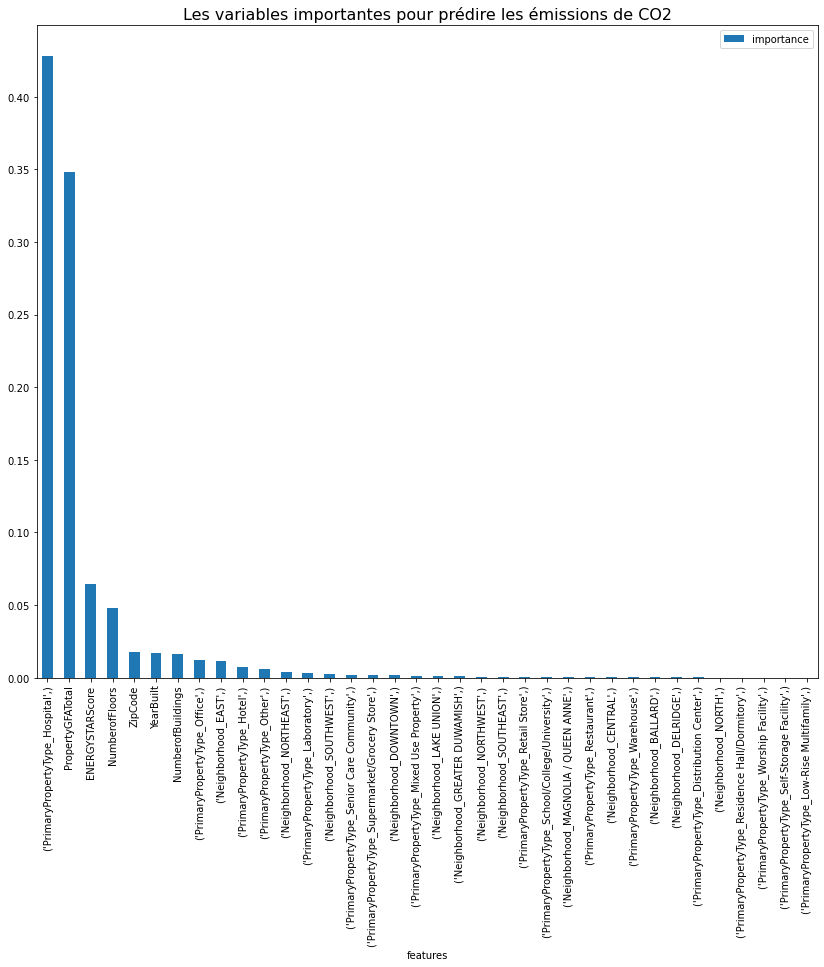

In [7]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["TotalGHGEmissions"]

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

importance = model.feature_importances_

features = pd.DataFrame(X.columns,columns=['features']).astype(str)
importance_df = pd.DataFrame(importance,columns=["importance"])

features_importance = pd.concat([features,importance_df],axis=1)
importance_sort = features_importance.sort_values(by='importance', ascending=False)

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
ax = importance_sort.plot.bar(x="features",y="importance",figsize=(14,12))
ax.set_title("Les variables importantes pour prédire les émissions de CO2", fontsize=16)

Text(0.5, 1.0, 'Les variables les plus importantes pour prédire les émissions \nde CO2 dans la dataset finale')

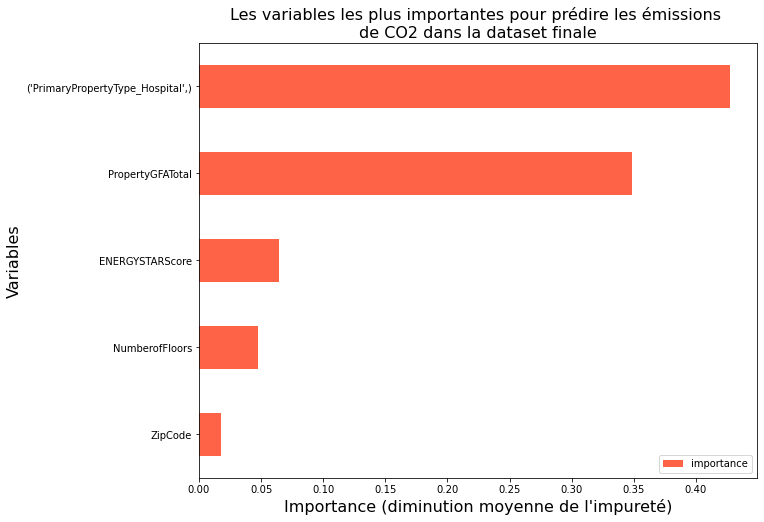

In [8]:
fig = importance_sort[:5].sort_values(by="importance",ascending=True).plot.barh(x="features", y="importance",figsize=(10,8),color="tomato")
plt.xlabel("Importance (diminution moyenne de l'impureté)", fontsize=16)
plt.ylabel('Variables', fontsize=16)
fig.set_title("Les variables les plus importantes pour prédire les émissions \nde CO2 dans la dataset finale",fontsize=16)

In [9]:
score = cross_val_score(model, X, y).mean()
print("Score de la performance de l'estimateur RandomForestRegressor pour la selection des variables \npour prédire les émissions du CO2 = %.2f" % score)

Score de la performance de l'estimateur RandomForestRegressor pour la selection des variables 
pour prédire les émissions du CO2 = 0.87


- Variables importantes dans la prédiction de l'émission de l'énergie :

Feature: 0, Score: 0.00016
Feature: 1, Score: 0.28654
Feature: 2, Score: 0.00225
Feature: 3, Score: 0.00129
Feature: 4, Score: 0.00002
Feature: 5, Score: 0.00860
Feature: 6, Score: 0.00251
Feature: 7, Score: 0.03948
Feature: 8, Score: 0.00001
Feature: 9, Score: 0.00014
Feature: 10, Score: 0.00056
Feature: 11, Score: 0.00108
Feature: 12, Score: 0.00011
Feature: 13, Score: 0.00057
Feature: 14, Score: 0.00325
Feature: 15, Score: 0.00121
Feature: 16, Score: 0.00005
Feature: 17, Score: 0.00009
Feature: 18, Score: 0.00135
Feature: 19, Score: 0.00030
Feature: 20, Score: 0.00356
Feature: 21, Score: 0.00469
Feature: 22, Score: 0.00158
Feature: 23, Score: 0.00120
Feature: 24, Score: 0.00044
Feature: 25, Score: 0.00010
Feature: 26, Score: 0.00064
Feature: 27, Score: 0.00125
Feature: 28, Score: 0.00032
Feature: 29, Score: 0.00086
Feature: 30, Score: 0.01305
Feature: 31, Score: 0.00071
Feature: 32, Score: 0.06118
Feature: 33, Score: 0.47904
Feature: 34, Score: 0.01176
Feature: 35, Score: 0.07007


Text(0.5, 1.0, "Les variables importantes pour prédire la consommation totale de l'énergie")

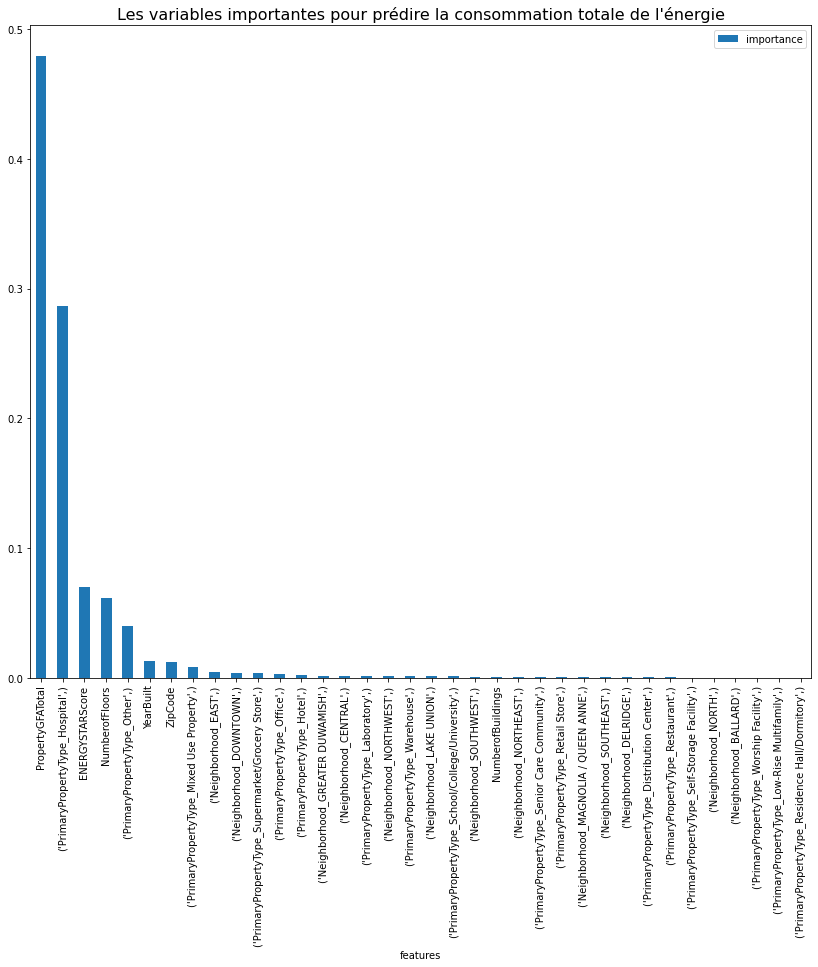

In [10]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)"]

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

importance = model.feature_importances_

features = pd.DataFrame(X.columns,columns=['features']).astype(str)
importance_df = pd.DataFrame(importance,columns=["importance"])

features_importance = pd.concat([features,importance_df],axis=1)
importance_sort = features_importance.sort_values(by='importance', ascending=False)

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
ax = importance_sort.plot.bar(x="features",y="importance",figsize=(14,12))
ax.set_title("Les variables importantes pour prédire la consommation totale de l'énergie", fontsize=16)

Text(0.5, 1.0, "Les variables les plus importantes pour prédire \nla consommation totale de l'énergie")

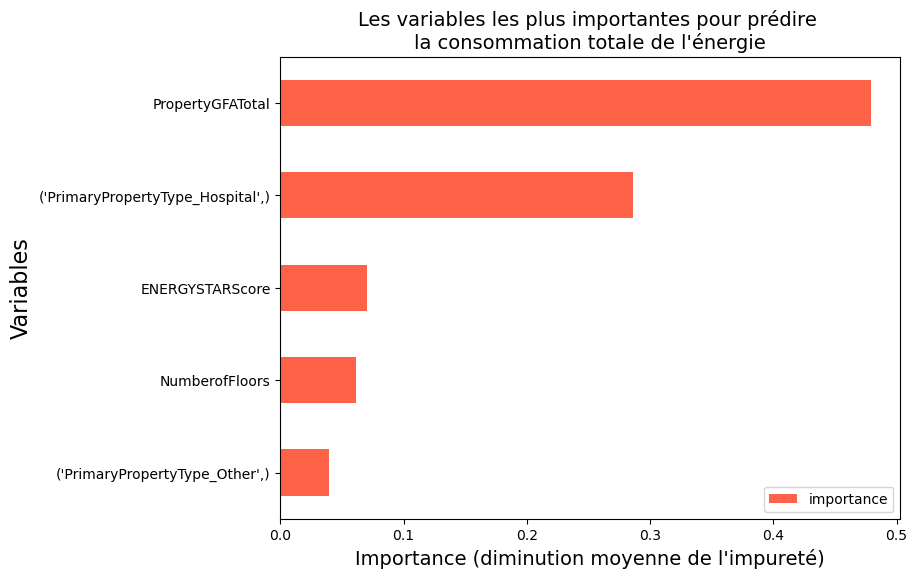

In [462]:
fig = importance_sort[:5].sort_values(by="importance",ascending=True).plot.barh(x="features", y="importance",figsize=(8,6),color="tomato")
plt.xlabel("Importance (diminution moyenne de l'impureté)", fontsize=14)
plt.ylabel('Variables', fontsize=16)
fig.set_title("Les variables les plus importantes pour prédire \nla consommation totale de l'énergie",fontsize=14)

In [12]:
score = cross_val_score(model, X, y).mean()
print("Score de la performance de l'estimateur RandomForestRegressor pour la selection des variables pour prédire la consommation totale de l'énergie = %.2f" % score)

Score de la performance de l'estimateur RandomForestRegressor pour la selection des variables pour prédire la consommation totale de l'énergie = 0.84


### Algorithmes de prédiction
Je vais d'abord chercher le meilleur algorithme pour prédire les émissions du CO2, pour cela je vais commencer à créer un modèle de base "baseline" avec DummyRegressor qui sert à comparer les vrais algorithmes avec l'algorithme Dummy.

### Regression Dummy 

Coefficient de détermination R2 de l'algorithme Dummy sur le jeu de test : -0.00
RMSE de l'algorithme Dummy sur le jeu de test : 622.27
MAE de l'algorithme Dummy sur le jeu de test : 177.99
Le temps d'execution de l'algorithme Dummy sur le jeu de test : 0.00s


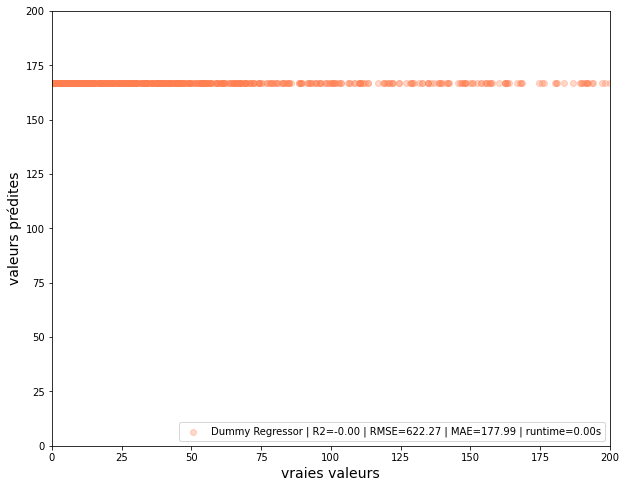

In [13]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["TotalGHGEmissions"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

start_time = timeit.default_timer()
dum = dummy.DummyRegressor(strategy='mean')
dum.fit(X_train_std, y_train)

y_pred_dum = dum.predict(X_test_std)
elapsed = timeit.default_timer() - start_time

R2 = metrics.r2_score(y_test, y_pred_dum)
RMSE = metrics.mean_squared_error(y_test, y_pred_dum,squared=False)
MAE = metrics.mean_absolute_error(y_test, y_pred_dum)

fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_dum,alpha=0.3,color='coral', label= "Dummy Regressor | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(R2,RMSE,MAE,elapsed))
plt.ylim([0, 200])
plt.xlim([0, 200])
plt.xlabel('vraies valeurs', fontsize=14,)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right")

print("Coefficient de détermination R2 de l'algorithme Dummy sur le jeu de test : {:.2f}".format(metrics.r2_score(y_test, y_pred_dum)))
print("RMSE de l'algorithme Dummy sur le jeu de test : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_dum,squared=False)))
print("MAE de l'algorithme Dummy sur le jeu de test : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_dum)))
print("Le temps d'execution de l'algorithme Dummy sur le jeu de test : {:.2f}s".format(elapsed))

**On voit que l'algorithme naïf Dummy ne permet pas de prédire éfficacement les émissions de CO2 et les résultats des métriques ne sont pas bonnes**

### Régression linéaire / Linear regression

- Voici les résultats obtenus avec l'algorithme Linear Regression :
Coefficient de détermination R2 de l'algorithme Linear Regression sur le jeu de test : 0.56
RMSE de l'algorithme Linear Regression sur le jeu de test : 411.73
MAE de l'algorithme Linear Regression sur le jeu de test : 143.69
Le temps d'execution de l'algorithme Linear Regression sur le jeu de test : 0.02s


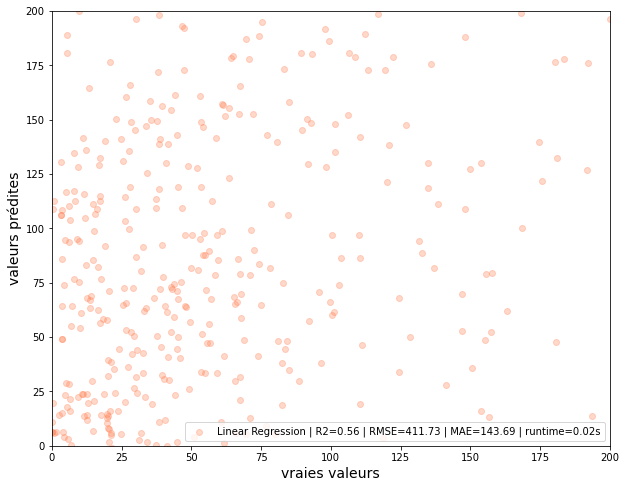

In [14]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["TotalGHGEmissions"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42) 
#répartition des données en données train et données test

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)
#normaliser les données de sorte que les variables auront μ = 0 et σ = 1

start_time = timeit.default_timer()
reg = LinearRegression().fit(X_train_std,y_train)
y_pred_reg = reg.predict(X_test_std)
elapsed = timeit.default_timer() - start_time 
#calculer le temps de l'éxecution de l'algorithme

R2 = metrics.r2_score(y_test, y_pred_reg)
RMSE = metrics.mean_squared_error(y_test, y_pred_reg,squared=False)
MAE = metrics.mean_absolute_error(y_test, y_pred_reg)

fig = plt.figure(figsize=(10,8))

plt.scatter(y_test,y_pred_reg,alpha=0.3,color='coral', label= "Linear Regression | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(R2,RMSE,MAE,elapsed))
plt.ylim([0, 200])
plt.xlim([0, 200])
plt.xlabel('vraies valeurs', fontsize=14,)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right")

print("- Voici les résultats obtenus avec l'algorithme Linear Regression :")
print("Coefficient de détermination R2 de l'algorithme Linear Regression sur le jeu de test : {:.2f}".format(metrics.r2_score(y_test, y_pred_reg)))
print("RMSE de l'algorithme Linear Regression sur le jeu de test : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_reg,squared=False)))
print("MAE de l'algorithme Linear Regression sur le jeu de test : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_reg)))
print("Le temps d'execution de l'algorithme Linear Regression sur le jeu de test : {:.2f}s".format(elapsed))

**L'algorithme de régression linéaire permet de prédire un peu mieux les émissions de CO2 par rapport à l'algorithme Dummy mais globalement les résultats des métriques ne sont pas bonnes**

### Régression Ridge / Ridge regression (Modèle linéaire)

Résultats de la validation croisée de la régression ridge pour:
r2 = 0.517 (+/-0.148) for {'alpha': 0.01}
r2 = 0.517 (+/-0.148) for {'alpha': 0.1}
r2 = 0.517 (+/-0.148) for {'alpha': 1.0}
r2 = 0.520 (+/-0.145) for {'alpha': 10.0}
r2 = 0.539 (+/-0.120) for {'alpha': 100.0}
MAE = 147.678 (+/-20.806) for {'alpha': 0.01}
MAE = 147.673 (+/-20.805) for {'alpha': 0.1}
MAE = 147.630 (+/-20.793) for {'alpha': 1.0}
MAE = 147.201 (+/-20.673) for {'alpha': 10.0}
MAE = 143.488 (+/-19.631) for {'alpha': 100.0}
RMSE = 350.807 (+/-88.166) for {'alpha': 0.01}
RMSE = 350.799 (+/-88.155) for {'alpha': 0.1}
RMSE = 350.719 (+/-88.045) for {'alpha': 1.0}
RMSE = 349.941 (+/-86.989) for {'alpha': 10.0}
RMSE = 344.359 (+/-79.981) for {'alpha': 100.0}


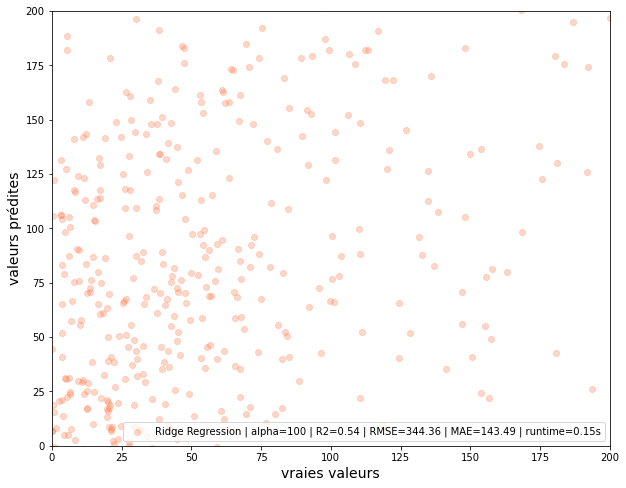

In [15]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["TotalGHGEmissions"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

alpha_range = np.logspace(-2, 2, 5)

param_grid = {'alpha': alpha_range}

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}

start_time = timeit.default_timer()
grid_pred_rdg = model_selection.GridSearchCV(# recherche des meilleurs hyperparamètres avec GridSearchGrid
        Ridge(random_state=42),
        param_grid,
        refit='r2',
        cv=5,  
        scoring= score)
                                    
grid_pred_rdg.fit(X_train_std, y_train)

y_pred_rdg = grid_pred_rdg.predict(X_test_std)

elapsed = timeit.default_timer() - start_time

print("Résultats de la validation croisée de la régression ridge pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_rdg.cv_results_['mean_test_r2'], 
        grid_pred_rdg.cv_results_['std_test_r2'], 
        grid_pred_rdg.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_rdg.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_rdg.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_rdg.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_rdg.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_rdg.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_rdg.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

best_RMSE = min(grid_pred_rdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_rdg.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_rdg.cv_results_['mean_test_neg_mean_absolute_error'])

fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_rdg,alpha=0.3,color='coral', label= "Ridge Regression | alpha=100 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.ylim([0, 200])
plt.xlim([0, 200])
plt.xlabel('vraies valeurs', fontsize=14,)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right")

In [16]:
print("- Voici les résultats obtenus avec l'algorithme Ridge Regression:")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_rdg.best_params_)
print("Le meilleur coefficient de détermination R2 de l'algorithme Ridge Regression sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme Ridge Regression sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme Ridge Regression sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme Ridge Regression sur le jeu de test : {:.2f}s".format(elapsed))

- Voici les résultats obtenus avec l'algorithme Ridge Regression:
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'alpha': 100.0}
Le meilleur coefficient de détermination R2 de l'algorithme Ridge Regression sur le jeu de test : 0.54
Le meilleur RMSE de l'algorithme Ridge Regression sur le jeu de test : 344.36
Le meilleur MAE de l'algorithme Ridge Regression sur le jeu de test : 143.49
Le temps d'execution de l'algorithme Ridge Regression sur le jeu de test : 0.15s


**La régularisation Ridge permet une meilleur prédiction que la régression linéaire au niveau du résultat du RMSE**

### Régression Ridge à noyau / Kernel Ridge regression ( Modèle non linéaire)

Résultats de la validation croisée de la régression ridge à noyau pour:
r2 = 0.772 (+/-0.108) for {'alpha': 0.01, 'gamma': 0.01}
r2 = 0.152 (+/-0.110) for {'alpha': 0.01, 'gamma': 0.1}
r2 = 0.099 (+/-0.078) for {'alpha': 0.01, 'gamma': 1.0}
r2 = 0.031 (+/-0.044) for {'alpha': 0.01, 'gamma': 10.0}
r2 = 0.759 (+/-0.103) for {'alpha': 0.1, 'gamma': 0.01}
r2 = 0.158 (+/-0.098) for {'alpha': 0.1, 'gamma': 0.1}
r2 = 0.096 (+/-0.077) for {'alpha': 0.1, 'gamma': 1.0}
r2 = 0.028 (+/-0.042) for {'alpha': 0.1, 'gamma': 10.0}
r2 = 0.655 (+/-0.083) for {'alpha': 1.0, 'gamma': 0.01}
r2 = 0.133 (+/-0.086) for {'alpha': 1.0, 'gamma': 0.1}
r2 = 0.051 (+/-0.050) for {'alpha': 1.0, 'gamma': 1.0}
r2 = -0.013 (+/-0.022) for {'alpha': 1.0, 'gamma': 10.0}
r2 = 0.313 (+/-0.116) for {'alpha': 10.0, 'gamma': 0.01}
r2 = 0.035 (+/-0.043) for {'alpha': 10.0, 'gamma': 0.1}
r2 = -0.064 (+/-0.022) for {'alpha': 10.0, 'gamma': 1.0}
r2 = -0.094 (+/-0.036) for {'alpha': 10.0, 'gamma': 10.0}
r2 = 0.043 (+/-0.036) for {'a

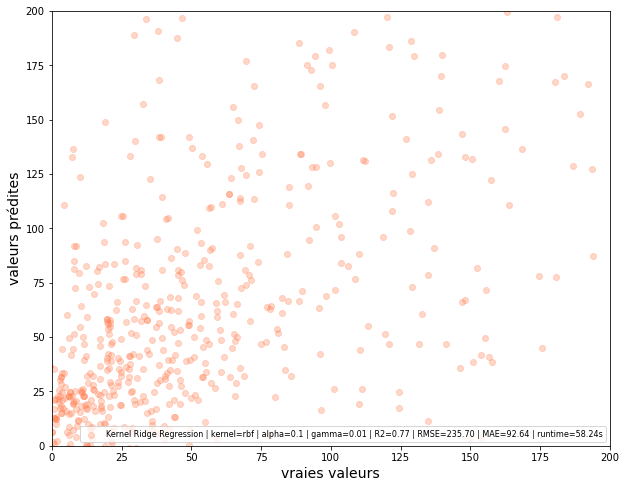

In [17]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["TotalGHGEmissions"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
#répartition des données en données train et données test

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)
#normaliser les données de sorte que les variables auront μ = 0 et σ = 1

alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}
#range des hyperparamètres à évaluer

score = {'r2':make_scorer(r2_score),\
         'neg_mean_absolute_error':make_scorer(mean_absolute_error),\
         'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}
#différents métriques utilisés

start_time = timeit.default_timer()
grid_pred_krdg = model_selection.GridSearchCV( # recherche des meilleurs hyperparamètres avec GridSearchGrid
        kernel_ridge.KernelRidge(kernel='rbf'),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_krdg.fit(X_train_std, y_train) #application de l'algorithme de prédiction sur les données train

y_pred_krdg = grid_pred_krdg.predict(X_test_std) #prédiction des valeurs des émissions avec les données test
elapsed = timeit.default_timer() - start_time #calcule du temps de d'éxecution de l'algorithme

print("Résultats de la validation croisée de la régression ridge à noyau pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_krdg.cv_results_['mean_test_r2'], 
        grid_pred_krdg.cv_results_['std_test_r2'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_krdg.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_krdg.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))
    
best_RMSE = min(grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_krdg.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'])

fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_krdg,alpha=0.3,color='coral',label= "Kernel Ridge Regression | kernel=rbf | alpha=0.1 | gamma=0.01 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.xlim([0,200])
plt.ylim([0,200])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 8})

In [18]:
print("- Voici les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type \n Radial Basis Function (RBF) :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_krdg.best_params_)
best_RMSE = min(grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_krdg.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 de l'algorithme Kernel Ridge Regression sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme Kernel Ridge Regression sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme Kernel Ridge Regression sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme Kernel Ridge Regression sur le jeu de test : {:.2f}s".format(elapsed))

- Voici les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type 
 Radial Basis Function (RBF) :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'alpha': 0.01, 'gamma': 0.01}
Le meilleur coefficient de détermination R2 de l'algorithme Kernel Ridge Regression sur le jeu de test : 0.77
Le meilleur RMSE de l'algorithme Kernel Ridge Regression sur le jeu de test : 235.70
Le meilleur MAE de l'algorithme Kernel Ridge Regression sur le jeu de test : 92.64
Le temps d'execution de l'algorithme Kernel Ridge Regression sur le jeu de test : 58.24s


**La Regression Ridge à noyau RBF permets d'obtenir des résultats plus intéressants avec tout les métriques par rapport à la regression linéaire et la regression Ridge à noyau linéaire mais le temps d'exécusion de l'estimateur est un peu plus long**

### Méthode des k plus proches voisins / k-nearest neighbors algorithm

In [63]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["TotalGHGEmissions"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}
start_time = timeit.default_timer()
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsRegressor(),
    param_grid,
    refit='r2',
    cv=5,           
    scoring=score)

clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
elapsed = timeit.default_timer() - start_time

print("Meilleur hyperparamètre sur le jeu d'entraînement:")
print(clf.best_params_)
best_RMSE = min(clf.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(clf.cv_results_['mean_test_r2'])
best_MAE = min(clf.cv_results_['mean_test_neg_mean_absolute_error'])

print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_r2'], 
        clf.cv_results_['std_test_r2'],  
        clf.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean,
        std,
        params
    ) )
for mean_mae, std_mae, params in zip(
        clf.cv_results_['mean_test_neg_mean_absolute_error'], 
        clf.cv_results_['std_test_neg_mean_absolute_error'], 
        clf.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        clf.cv_results_['mean_test_neg_root_mean_squared_error'], 
        clf.cv_results_['std_test_neg_root_mean_squared_error'], 
        clf.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))


Meilleur hyperparamètre sur le jeu d'entraînement:
{'n_neighbors': 3}
Résultats de la validation croisée :
r2 = 0.599 (+/-0.188) for {'n_neighbors': 3}
r2 = 0.545 (+/-0.140) for {'n_neighbors': 5}
r2 = 0.556 (+/-0.123) for {'n_neighbors': 7}
r2 = 0.539 (+/-0.140) for {'n_neighbors': 9}
r2 = 0.530 (+/-0.149) for {'n_neighbors': 11}
r2 = 0.504 (+/-0.141) for {'n_neighbors': 13}
r2 = 0.478 (+/-0.136) for {'n_neighbors': 15}
MAE = 102.772 (+/-17.610) for {'n_neighbors': 3}
MAE = 110.343 (+/-17.242) for {'n_neighbors': 5}
MAE = 112.502 (+/-18.010) for {'n_neighbors': 7}
MAE = 113.769 (+/-18.790) for {'n_neighbors': 9}
MAE = 114.309 (+/-19.548) for {'n_neighbors': 11}
MAE = 116.328 (+/-19.574) for {'n_neighbors': 13}
MAE = 118.151 (+/-20.259) for {'n_neighbors': 15}
RMSE = 304.351 (+/-74.189) for {'n_neighbors': 3}
RMSE = 340.577 (+/-84.777) for {'n_neighbors': 5}
RMSE = 351.438 (+/-118.444) for {'n_neighbors': 7}
RMSE = 357.612 (+/-123.214) for {'n_neighbors': 9}
RMSE = 361.581 (+/-126.584)

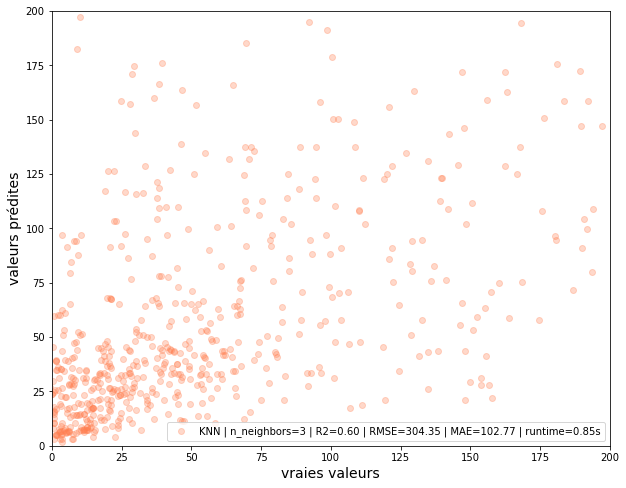

In [64]:
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred,alpha=0.3,color='coral',label= "KNN | n_neighbors=3 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.xlim([0,200])
plt.ylim([0,200])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 10})

In [65]:
print("Voici les résultats obtenus avec l'algorithme KNN Regressor :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", clf.best_params_)
print("Le meilleur coefficient de détermination R2 de l'algorithme KNN sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme KNN sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme KNN sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme KNN sur le jeu de test : {:.2f}s".format(elapsed))

Voici les résultats obtenus avec l'algorithme KNN Regressor :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'n_neighbors': 3}
Le meilleur coefficient de détermination R2 de l'algorithme KNN sur le jeu de test : 0.60
Le meilleur RMSE de l'algorithme KNN sur le jeu de test : 304.35
Le meilleur MAE de l'algorithme KNN sur le jeu de test : 102.77
Le temps d'execution de l'algorithme KNN sur le jeu de test : 0.85s


**Le modèle KNN nous donne un résultat plus intéressant au niveau de l'écart quadratique moyen RMSE pour lequel on observe une diminution importante par rapport au modèles Ridge**

### L'algorithme du gradient boosting / Gradient Boosting Regressor

Les meilleurs paramètres de l'algorithme XGBoost sont {'learning_rate': 0.08, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.5}
Résultats de la validation croisée de le boost gradient pour:
r2 = 0.622 (+/-0.052) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.550 (+/-0.070) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
r2 = 0.475 (+/-0.077) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.1}
r2 = 0.717 (+/-0.098) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
r2 = 0.661 (+/-0.073) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
r2 = 0.610 (+/-0.064) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.1}
r2 = 0.675 (+/-0.034) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.619 (+/-0.064) for {'learning_rate': 0.01, 'max_depth': 5, 'n_

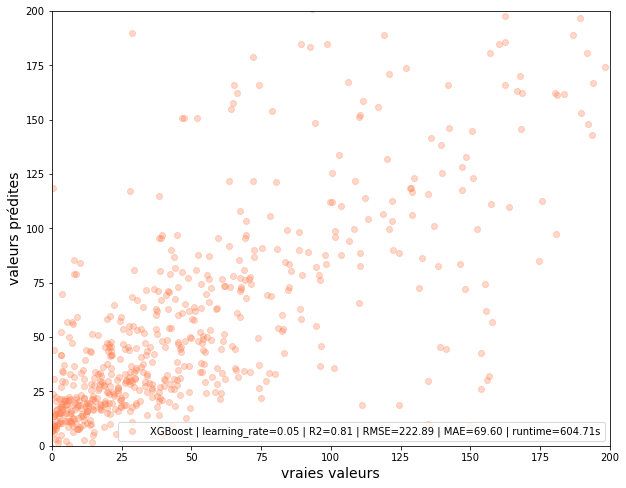

In [22]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["TotalGHGEmissions"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)


subsample = [0.9,0.5,0.1]
n_estimators = [100,200]
max_depth = [3,5,8,10]
learning_range = np.arange(0.01,0.11,0.01)

param_grid = {'max_depth':max_depth,'learning_rate':learning_range,'subsample':subsample,'n_estimators':n_estimators}

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}


start_time = timeit.default_timer()
grid_pred_xboost = model_selection.GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_xboost.fit(X_train_std, y_train)

y_pred_xboost = grid_pred_xboost.predict(X_test_std)

elapsed = timeit.default_timer() - start_time

print ("Les meilleurs paramètres de l'algorithme XGBoost sont",grid_pred_xboost.best_params_)
print("Résultats de la validation croisée de le boost gradient pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_xboost.cv_results_['mean_test_r2'], 
        grid_pred_xboost.cv_results_['std_test_r2'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_xboost.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_xboost.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

best_RMSE = min(grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_xboost.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'])

fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_xboost,alpha=0.3,color='coral',label= "XGBoost | learning_rate=0.05 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.xlim([0,200])
plt.ylim([0,200])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 10})

In [23]:
print("Voici les résultats obtenus avec l'algorithme gradient boost Regression :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_xboost.best_params_)
print("Le meilleur coefficient de détermination R2 de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}s".format(elapsed))

Voici les résultats obtenus avec l'algorithme gradient boost Regression :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'learning_rate': 0.08, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.5}
Le meilleur coefficient de détermination R2 de l'algorithme Gradient Boosting Regression sur le jeu de test : 0.81
Le meilleur RMSE de l'algorithme Gradient Boosting Regression sur le jeu de test : 222.89
Le meilleur MAE de l'algorithme Gradient Boosting Regression sur le jeu de test : 69.60
Le temps d'execution de l'algorithme Gradient Boosting Regression sur le jeu de test : 604.71s


### Support vector regression (SVR) à noyau linéaire (modèle linéaire)

In [24]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["TotalGHGEmissions"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

c_range = np.logspace(-2, 2, 6)
gamma_range = np.logspace(-2, 2, 6)
tuned_parameters = [{'kernel': ['linear'], 'C': c_range,'gamma':gamma_range}]

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}

svr = SVR()
grid_svr = model_selection.GridSearchCV(svr,param_grid=tuned_parameters,refit="r2",cv=5,scoring=score)
grid_svr.fit(X_train_std, y_train)
y_pred_svr = grid_svr.predict(X_test_std)
elapsed = timeit.default_timer() - start_time

print("Résultats de la validation croisée de l'algorithme SVR pour:")
for mean_r2, std_r2, params in zip(
        grid_svr.cv_results_['mean_test_r2'], 
        grid_svr.cv_results_['std_test_r2'], 
        grid_svr.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_svr.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_svr.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_svr.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_svr.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_svr.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_svr.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))
    
best_RMSE = min(grid_svr.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_svr.cv_results_['mean_test_r2'])
best_MAE = min(grid_svr.cv_results_['mean_test_neg_mean_absolute_error'])

Résultats de la validation croisée de l'algorithme SVR pour:
r2 = -0.029 (+/-0.012) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}
r2 = -0.029 (+/-0.012) for {'C': 0.01, 'gamma': 0.06309573444801933, 'kernel': 'linear'}
r2 = -0.029 (+/-0.012) for {'C': 0.01, 'gamma': 0.3981071705534973, 'kernel': 'linear'}
r2 = -0.029 (+/-0.012) for {'C': 0.01, 'gamma': 2.5118864315095824, 'kernel': 'linear'}
r2 = -0.029 (+/-0.012) for {'C': 0.01, 'gamma': 15.848931924611142, 'kernel': 'linear'}
r2 = -0.029 (+/-0.012) for {'C': 0.01, 'gamma': 100.0, 'kernel': 'linear'}
r2 = 0.085 (+/-0.047) for {'C': 0.06309573444801933, 'gamma': 0.01, 'kernel': 'linear'}
r2 = 0.085 (+/-0.047) for {'C': 0.06309573444801933, 'gamma': 0.06309573444801933, 'kernel': 'linear'}
r2 = 0.085 (+/-0.047) for {'C': 0.06309573444801933, 'gamma': 0.3981071705534973, 'kernel': 'linear'}
r2 = 0.085 (+/-0.047) for {'C': 0.06309573444801933, 'gamma': 2.5118864315095824, 'kernel': 'linear'}
r2 = 0.085 (+/-0.047) for {'C': 0.06309573

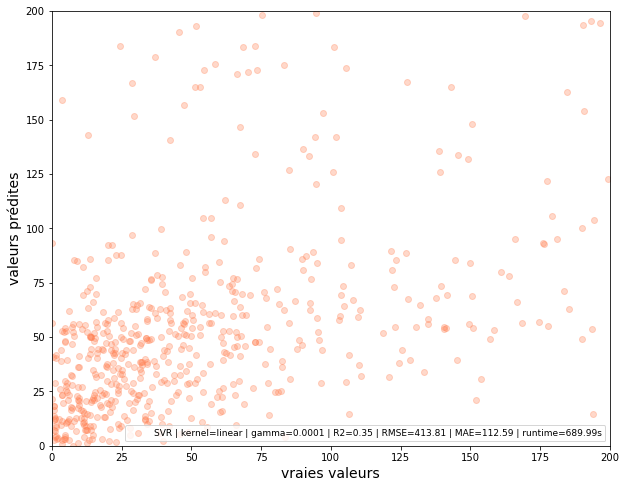

In [25]:
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_svr,alpha=0.3,color='coral',label= "SVR | kernel=linear | gamma=0.0001 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.xlim([0,200])
plt.ylim([0,200])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 9}) 

In [26]:
print("Voici les résultats obtenus avec l'algorithme SVR :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_svr.best_params_)
print("Le meilleur coefficient de détermination R2 de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme SVR sur le jeu de test : {:.2f}s".format(elapsed))   

Voici les résultats obtenus avec l'algorithme SVR :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'C': 2.5118864315095824, 'gamma': 0.01, 'kernel': 'linear'}
Le meilleur coefficient de détermination R2 de l'algorithme SVR sur le jeu de test : 0.35
Le meilleur RMSE de l'algorithme SVR sur le jeu de test : 413.81
Le meilleur MAE de l'algorithme SVR sur le jeu de test : 112.59
Le temps d'execution de l'algorithme SVR sur le jeu de test : 689.99s


### Support vector regression (SVR) à noyau rbf (modèle non linéaire)

In [27]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["TotalGHGEmissions"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

c_range = np.logspace(-2, 2, 6)
gamma_range = np.logspace(-2, 2, 6)
tuned_parameters = [{'kernel': ['rbf'], 'C': c_range,'gamma':gamma_range}]

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}

svr = SVR()
grid_svr = model_selection.GridSearchCV(svr,param_grid=tuned_parameters,refit="r2",cv=5,scoring=score)
grid_svr.fit(X_train_std, y_train)
y_pred_svr = grid_svr.predict(X_test_std)
elapsed = timeit.default_timer() - start_time

print("Résultats de la validation croisée de l'algorithme SVR pour:")
for mean_r2, std_r2, params in zip(
        grid_svr.cv_results_['mean_test_r2'], 
        grid_svr.cv_results_['std_test_r2'], 
        grid_svr.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_svr.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_svr.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_svr.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_svr.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_svr.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_svr.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))


best_RMSE = min(grid_svr.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_svr.cv_results_['mean_test_r2'])
best_MAE = min(grid_svr.cv_results_['mean_test_neg_mean_absolute_error'])


Résultats de la validation croisée de l'algorithme SVR pour:
r2 = -0.058 (+/-0.031) for {'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}
r2 = -0.056 (+/-0.030) for {'C': 1.0, 'gamma': 0.0003727593720314938, 'kernel': 'rbf'}
r2 = -0.050 (+/-0.027) for {'C': 1.0, 'gamma': 0.0013894954943731374, 'kernel': 'rbf'}
r2 = -0.035 (+/-0.019) for {'C': 1.0, 'gamma': 0.005179474679231213, 'kernel': 'rbf'}
r2 = -0.028 (+/-0.012) for {'C': 1.0, 'gamma': 0.019306977288832496, 'kernel': 'rbf'}
r2 = -0.040 (+/-0.017) for {'C': 1.0, 'gamma': 0.07196856730011514, 'kernel': 'rbf'}
r2 = -0.050 (+/-0.024) for {'C': 1.0, 'gamma': 0.2682695795279725, 'kernel': 'rbf'}
r2 = -0.055 (+/-0.028) for {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
r2 = -0.056 (+/-0.030) for {'C': 3.72759372031494, 'gamma': 0.0001, 'kernel': 'rbf'}
r2 = -0.049 (+/-0.027) for {'C': 3.72759372031494, 'gamma': 0.0003727593720314938, 'kernel': 'rbf'}
r2 = -0.029 (+/-0.017) for {'C': 3.72759372031494, 'gamma': 0.0013894954943731374, 'kernel': 'rbf'

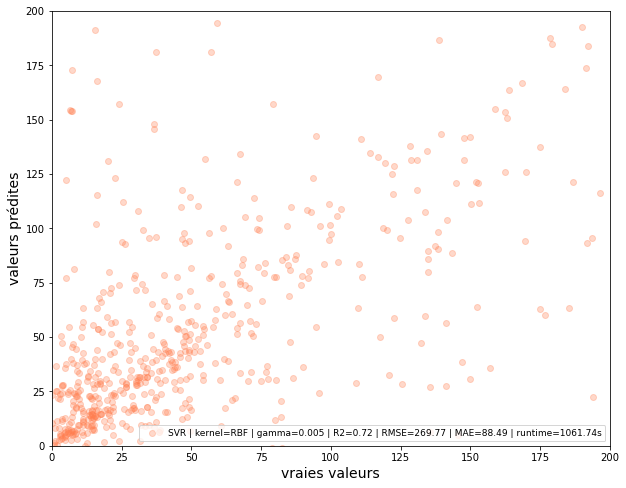

In [28]:
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_svr,alpha=0.3,color='coral',label= "SVR | kernel=RBF | gamma=0.005 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.xlim([0,200])
plt.ylim([0,200])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 9}) 

In [29]:
print("Voici les résultats obtenus avec l'algorithme SVR :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_svr.best_params_)
print("Le meilleur coefficient de détermination R2 de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme SVR sur le jeu de test : {:.2f}s".format(elapsed))   

Voici les résultats obtenus avec l'algorithme SVR :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'C': 10000.0, 'gamma': 0.019306977288832496, 'kernel': 'rbf'}
Le meilleur coefficient de détermination R2 de l'algorithme SVR sur le jeu de test : 0.72
Le meilleur RMSE de l'algorithme SVR sur le jeu de test : 269.77
Le meilleur MAE de l'algorithme SVR sur le jeu de test : 88.49
Le temps d'execution de l'algorithme SVR sur le jeu de test : 1061.74s


Text(0, 0.5, 'R2')

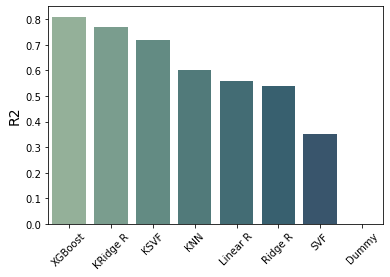

In [57]:
CO2_results_R2 = pd.DataFrame(np.array([[0,0.56,0.54,0.77,0.60,0.81,0.35,0.72]]), columns=["Dummy","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
CO2_results_R2=CO2_results_R2.sort_values(by=0,ascending=False,axis=1)
CO2_results_R2 = CO2_results_R2.T
CO2_results_R2.columns = ['R2']
sns.barplot(x = CO2_results_R2.index,y = CO2_results_R2["R2"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("R2",fontsize=14)

Text(0, 0.5, 'RMSE')

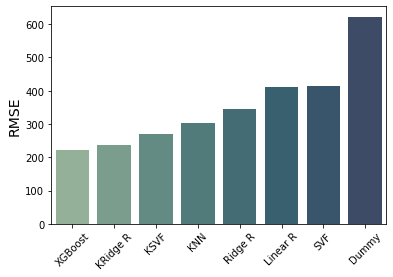

In [66]:
CO2_results_RMSE = pd.DataFrame(np.array([[622.27,411.73,344.36,235.70,304.35,222.89,413.81,269.77]]), columns=["Dummy","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
CO2_results_RMSE=CO2_results_RMSE.sort_values(by=0,ascending=True,axis=1)
CO2_results_RMSE = CO2_results_RMSE.T
CO2_results_RMSE.columns = ['RMSE']
sns.barplot(x = CO2_results_RMSE.index,y = CO2_results_RMSE["RMSE"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("RMSE",fontsize=14)

Text(0, 0.5, 'MAE')

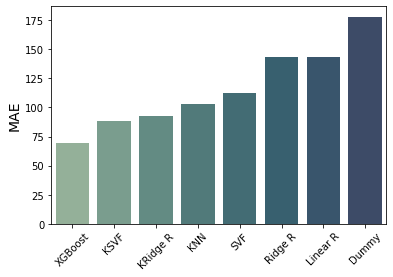

In [59]:
CO2_results_MAE = pd.DataFrame(np.array([[177.99,143.69,143.49,92.64,102.77,69.60,112.59,88.49]]), columns=["Dummy","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
CO2_results_MAE=CO2_results_MAE.sort_values(by=0,ascending=True,axis=1)
CO2_results_MAE = CO2_results_MAE.T
CO2_results_MAE.columns = ['MAE']
sns.barplot(x = CO2_results_MAE.index,y = CO2_results_MAE["MAE"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("MAE",fontsize=14)

Text(0, 0.5, 'Runtime')

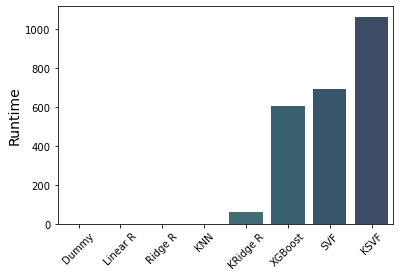

In [60]:
CO2_results_runtime = pd.DataFrame(np.array([[0,0.02,0.15,58.24,0.80,604.71,689.99,1061.74]]), columns=["Dummy","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
CO2_results_runtime=CO2_results_runtime.sort_values(by=0,ascending=True,axis=1)
CO2_results_runtime = CO2_results_runtime.T
CO2_results_runtime.columns = ['Runtime']
sns.barplot(x = CO2_results_runtime.index,y = CO2_results_runtime["Runtime"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Runtime",fontsize=14)

- **L'algorithme XGBoost permet d'obtenir des meilleurs résultats au niveau de tout les métriques pour effectuer cette prédiction. Cependant cet algorithme nécessite un temps d'exécution important**  

Maintenant je vais chercher le meilleur algorithme pour prédire l a consommation totale d'énergie, pour cela je vais commencer à créer un modèle de base "baseline" avec DummyRegressor qui sert à comparer les vrais algorithmes avec l'algorithme Dummy.

### Regression Dummy

Coefficient de détermination R2 de l'algorithme Dummy sur le jeu de test : -0.00
RMSE de l'algorithme Dummy sur le jeu de test : 20261762.48
MAE de l'algorithme Dummy sur le jeu de test : 7831402.92
Le temps d'execution de l'algorithme Dummy sur le jeu de test : 0.00s


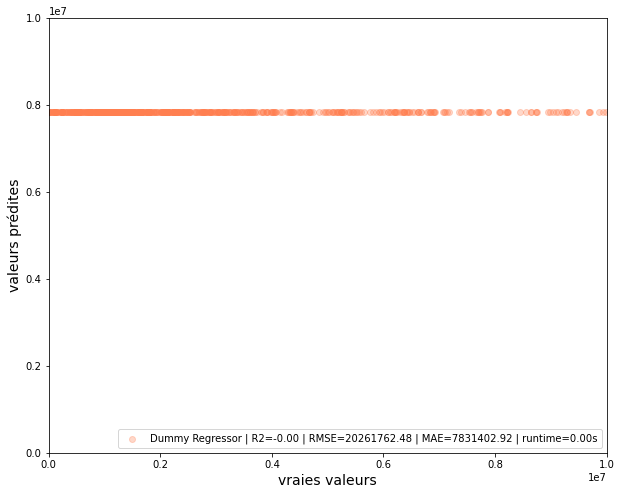

In [34]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

start_time = timeit.default_timer()
dum = dummy.DummyRegressor(strategy='mean')
dum.fit(X_train_std, y_train)

y_pred_dum = dum.predict(X_test_std)
elapsed = timeit.default_timer() - start_time

R2 = metrics.r2_score(y_test, y_pred_dum)
RMSE = metrics.mean_squared_error(y_test, y_pred_dum,squared=False)
MAE = metrics.mean_absolute_error(y_test, y_pred_dum)

fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_dum,alpha=0.3,color='coral', label= "Dummy Regressor | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(R2,RMSE,MAE,elapsed))
plt.ylim([0, 1e7])
plt.xlim([0, 1e7])
plt.xlabel('vraies valeurs', fontsize=14,)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right")

print("Coefficient de détermination R2 de l'algorithme Dummy sur le jeu de test : {:.2f}".format(metrics.r2_score(y_test, y_pred_dum)))
print("RMSE de l'algorithme Dummy sur le jeu de test : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_dum,squared=False)))
print("MAE de l'algorithme Dummy sur le jeu de test : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_dum)))
print("Le temps d'execution de l'algorithme Dummy sur le jeu de test : {:.2f}s".format(elapsed))

### Régression linéaire / Linear regression

- Voici les résultats obtenus avec l'algorithme Linear Regression :
Coefficient de détermination R2 de l'algorithme Linear Regression sur le jeu de test : 0.56
RMSE de l'algorithme Linear Regression sur le jeu de test : 13482354.62
MAE de l'algorithme Linear Regression sur le jeu de test : 4333841.75
Le temps d'execution de l'algorithme Linear Regression sur le jeu de test : 0.00s


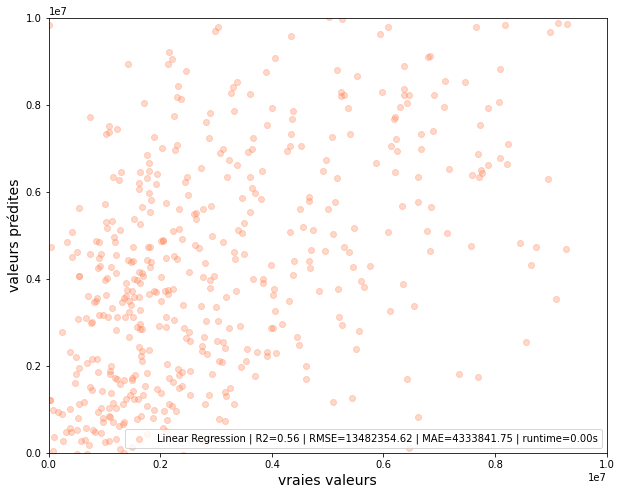

In [35]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

start_time = timeit.default_timer()
reg = LinearRegression().fit(X_train_std,y_train)
y_pred_reg = reg.predict(X_test_std)
elapsed = timeit.default_timer() - start_time

R2 = metrics.r2_score(y_test, y_pred_reg)
RMSE = metrics.mean_squared_error(y_test, y_pred_reg,squared=False)
MAE = metrics.mean_absolute_error(y_test, y_pred_reg)

fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_reg,alpha=0.3,color='coral', label= "Linear Regression | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(R2,RMSE,MAE,elapsed))
plt.ylim([0, 1e7])
plt.xlim([0, 1e7])
plt.xlabel('vraies valeurs', fontsize=14,)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right")

print("- Voici les résultats obtenus avec l'algorithme Linear Regression :")
print("Coefficient de détermination R2 de l'algorithme Linear Regression sur le jeu de test : {:.2f}".format(metrics.r2_score(y_test, y_pred_reg)))
print("RMSE de l'algorithme Linear Regression sur le jeu de test : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_reg,squared=False)))
print("MAE de l'algorithme Linear Regression sur le jeu de test : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_reg)))
print("Le temps d'execution de l'algorithme Linear Regression sur le jeu de test : {:.2f}s".format(elapsed))

### Régression Ridge / Ridge regression (modèle linéaire)

In [36]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

alpha_range = np.logspace(-2, 2, 5)

param_grid = {'alpha': alpha_range}

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}


start_time = timeit.default_timer()
grid_pred_rdg = model_selection.GridSearchCV(
        Ridge(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_rdg.fit(X_train_std, y_train)

y_pred_rdg = grid_pred_rdg.predict(X_test_std)

elapsed = timeit.default_timer() - start_time

In [37]:
print("Résultats de la validation croisée de la régression ridge pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_rdg.cv_results_['mean_test_r2'], 
        grid_pred_rdg.cv_results_['std_test_r2'], 
        grid_pred_rdg.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_rdg.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_rdg.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_rdg.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_rdg.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_rdg.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_rdg.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

Résultats de la validation croisée de la régression ridge pour:
r2 = 0.608 (+/-0.083) for {'alpha': 0.01}
r2 = 0.608 (+/-0.083) for {'alpha': 0.1}
r2 = 0.608 (+/-0.083) for {'alpha': 1.0}
r2 = 0.610 (+/-0.082) for {'alpha': 10.0}
r2 = 0.619 (+/-0.075) for {'alpha': 100.0}
MAE = 4488347.629 (+/-590743.777) for {'alpha': 0.01}
MAE = 4488246.189 (+/-590712.028) for {'alpha': 0.1}
MAE = 4487235.579 (+/-590394.359) for {'alpha': 1.0}
MAE = 4477542.618 (+/-587258.092) for {'alpha': 10.0}
MAE = 4402375.679 (+/-554662.117) for {'alpha': 100.0}
RMSE = 11132094.693 (+/-2597152.485) for {'alpha': 0.01}
RMSE = 11131917.559 (+/-2597058.287) for {'alpha': 0.1}
RMSE = 11130153.477 (+/-2596122.455) for {'alpha': 1.0}
RMSE = 11113221.676 (+/-2587361.872) for {'alpha': 10.0}
RMSE = 11001443.025 (+/-2545850.085) for {'alpha': 100.0}


In [38]:
print("- Voici les résultats obtenus avec l'algorithme Ridge Regression en utilisant un noyau de type \n Radial Basis Function (RBF) :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_rdg.best_params_)
best_RMSE = min(grid_pred_rdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_rdg.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_rdg.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 de l'algorithme Ridge Regression sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme Ridge Regression sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme Ridge Regression sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme Ridge Regression sur le jeu de test : {:.2f}s".format(elapsed))

- Voici les résultats obtenus avec l'algorithme Ridge Regression en utilisant un noyau de type 
 Radial Basis Function (RBF) :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'alpha': 100.0}
Le meilleur coefficient de détermination R2 de l'algorithme Ridge Regression sur le jeu de test : 0.62
Le meilleur RMSE de l'algorithme Ridge Regression sur le jeu de test : 11001443.03
Le meilleur MAE de l'algorithme Ridge Regression sur le jeu de test : 4402375.68
Le temps d'execution de l'algorithme Ridge Regression sur le jeu de test : 0.11s


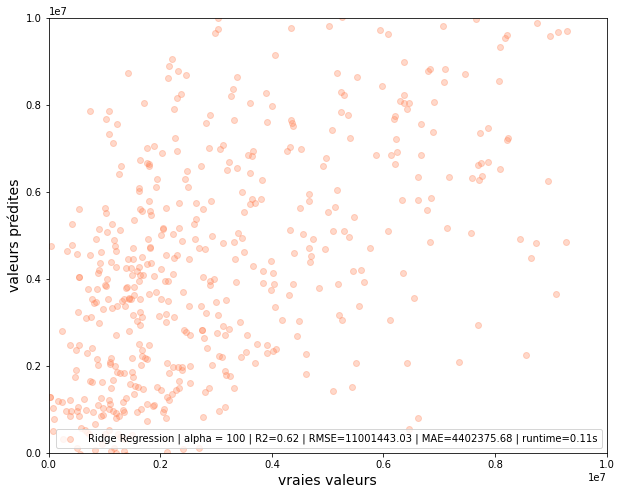

In [39]:
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_rdg,alpha=0.3,color='coral', label= "Ridge Regression | alpha = 100 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.ylim([0, 1e7])
plt.xlim([0, 1e7])
plt.xlabel('vraies valeurs', fontsize=14,)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right")

### Régression Ridge à noyau / Kernel Ridge regression ( Modèle non linéaire)

In [40]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)

param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}


start_time = timeit.default_timer()
grid_pred_krdg = model_selection.GridSearchCV(
        kernel_ridge.KernelRidge(kernel='rbf'),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_krdg.fit(X_train_std, y_train)
y_pred_krdg = grid_pred_krdg.predict(X_test_std)
elapsed = timeit.default_timer() - start_time

In [41]:
print("Résultats de la validation croisée de la régression ridge à noyau pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_krdg.cv_results_['mean_test_r2'], 
        grid_pred_krdg.cv_results_['std_test_r2'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_krdg.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_krdg.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

Résultats de la validation croisée de la régression ridge à noyau pour:
r2 = 0.769 (+/-0.066) for {'alpha': 0.01, 'gamma': 0.01}
r2 = 0.303 (+/-0.169) for {'alpha': 0.01, 'gamma': 0.1}
r2 = 0.174 (+/-0.113) for {'alpha': 0.01, 'gamma': 1.0}
r2 = 0.048 (+/-0.071) for {'alpha': 0.01, 'gamma': 10.0}
r2 = 0.748 (+/-0.072) for {'alpha': 0.1, 'gamma': 0.01}
r2 = 0.312 (+/-0.155) for {'alpha': 0.1, 'gamma': 0.1}
r2 = 0.173 (+/-0.112) for {'alpha': 0.1, 'gamma': 1.0}
r2 = 0.044 (+/-0.071) for {'alpha': 0.1, 'gamma': 10.0}
r2 = 0.655 (+/-0.088) for {'alpha': 1.0, 'gamma': 0.01}
r2 = 0.269 (+/-0.133) for {'alpha': 1.0, 'gamma': 0.1}
r2 = 0.099 (+/-0.074) for {'alpha': 1.0, 'gamma': 1.0}
r2 = -0.021 (+/-0.048) for {'alpha': 1.0, 'gamma': 10.0}
r2 = 0.385 (+/-0.127) for {'alpha': 10.0, 'gamma': 0.01}
r2 = 0.099 (+/-0.070) for {'alpha': 10.0, 'gamma': 0.1}
r2 = -0.103 (+/-0.027) for {'alpha': 10.0, 'gamma': 1.0}
r2 = -0.165 (+/-0.051) for {'alpha': 10.0, 'gamma': 10.0}
r2 = 0.084 (+/-0.052) for {'a

In [42]:
print("Voici les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type \n Radial Basis Function (RBF) :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_krdg.best_params_)
best_RMSE = min(grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_krdg.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 de l'algorithme Kernel Ridge Regression sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme Kernel Ridge Regression sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme Kernel Ridge Regression sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme Kernel Ridge Regression sur le jeu de test : {:.2f}s".format(elapsed))

Voici les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type 
 Radial Basis Function (RBF) :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'alpha': 0.01, 'gamma': 0.01}
Le meilleur coefficient de détermination R2 de l'algorithme Kernel Ridge Regression sur le jeu de test : 0.77
Le meilleur RMSE de l'algorithme Kernel Ridge Regression sur le jeu de test : 8560903.01
Le meilleur MAE de l'algorithme Kernel Ridge Regression sur le jeu de test : 3219968.82
Le temps d'execution de l'algorithme Kernel Ridge Regression sur le jeu de test : 63.84s


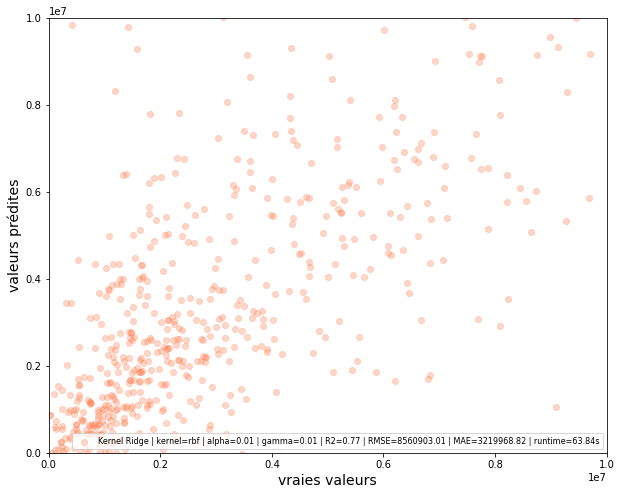

In [43]:
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_krdg,alpha=0.3,color='coral', label= "Kernel Ridge | kernel=rbf | alpha=0.01 | gamma=0.01 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.ylim([0, 1e7])
plt.xlim([0, 1e7])
plt.xlabel('vraies valeurs', fontsize=14,)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right")
plt.legend(loc="lower right", prop = {'size': 8})

### Méthode des k plus proches voisins / k-nearest neighbors algorithm

Résultats de la validation croisée :
r2 = 0.591 (+/-0.125) for {'n_neighbors': 3}
r2 = 0.533 (+/-0.118) for {'n_neighbors': 5}
r2 = 0.480 (+/-0.094) for {'n_neighbors': 7}
r2 = 0.452 (+/-0.102) for {'n_neighbors': 9}
r2 = 0.427 (+/-0.111) for {'n_neighbors': 11}
r2 = 0.426 (+/-0.091) for {'n_neighbors': 13}
r2 = 0.418 (+/-0.085) for {'n_neighbors': 15}
MAE = 3592698.210 (+/-514949.948) for {'n_neighbors': 3}
MAE = 3916600.385 (+/-585874.715) for {'n_neighbors': 5}
MAE = 4115879.773 (+/-554219.345) for {'n_neighbors': 7}
MAE = 4234193.914 (+/-427785.409) for {'n_neighbors': 9}
MAE = 4339462.926 (+/-391632.342) for {'n_neighbors': 11}
MAE = 4374783.420 (+/-404837.518) for {'n_neighbors': 13}
MAE = 4411815.677 (+/-435815.605) for {'n_neighbors': 15}
RMSE = 10211297.003 (+/-2570220.508) for {'n_neighbors': 3}
RMSE = 11072235.672 (+/-2928077.906) for {'n_neighbors': 5}
RMSE = 11726423.734 (+/-2962722.553) for {'n_neighbors': 7}
RMSE = 11951317.095 (+/-2875004.399) for {'n_neighbors': 9}
RMS

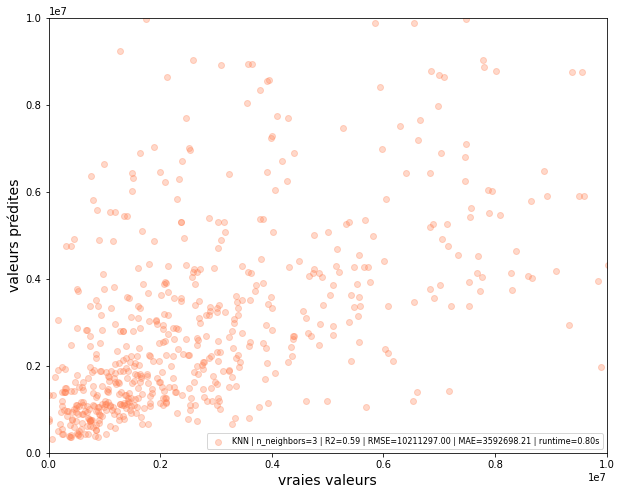

In [44]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}
start_time = timeit.default_timer()
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsRegressor(),
    param_grid,
    refit='r2',
    cv=5,           
    scoring=score)

clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
elapsed = timeit.default_timer() - start_time

print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_r2'], 
        clf.cv_results_['std_test_r2'],  
        clf.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean,
        std,
        params
    ) )
for mean_mae, std_mae, params in zip(
        clf.cv_results_['mean_test_neg_mean_absolute_error'], 
        clf.cv_results_['std_test_neg_mean_absolute_error'], 
        clf.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        clf.cv_results_['mean_test_neg_root_mean_squared_error'], 
        clf.cv_results_['std_test_neg_root_mean_squared_error'], 
        clf.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

print("Voici les résultats obtenus avec l'algorithme KNN Regressor :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", clf.best_params_)
best_RMSE = min(clf.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(clf.cv_results_['mean_test_r2'])
best_MAE = min(clf.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 de l'algorithme KNN sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme KNN sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme KNN sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme KNN sur le jeu de test : {:.2f}s".format(elapsed))
    
    
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred,alpha=0.3,color='coral', label= "KNN | n_neighbors=3 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.ylim([0, 1e7])
plt.xlim([0, 1e7])
plt.xlabel('vraies valeurs', fontsize=14,)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right")
plt.legend(loc="lower right", prop = {'size': 8})

### L'algorithme du gradient boosting / Gradient Boosting Regressor

In [45]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

subsample = [0.9,0.5,0.1]
n_estimators = [100,200]
max_depth = [3,5,8,10]
learning_range = np.arange(0.01,0.11,0.01)

param_grid = {'max_depth':max_depth,'learning_rate':learning_range,'subsample':subsample,'n_estimators':n_estimators}


start_time = timeit.default_timer()
grid_pred_xboost = model_selection.GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_xboost.fit(X_train_std, y_train)

y_pred_xboost = grid_pred_xboost.predict(X_test_std)

elapsed = timeit.default_timer() - start_time

In [46]:
print ("Les meilleurs paramètres de l'algorithme XGBoost sont",grid_pred_xboost.best_params_)
print("Résultats de la validation croisée de le boost gradient pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_xboost.cv_results_['mean_test_r2'], 
        grid_pred_xboost.cv_results_['std_test_r2'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_xboost.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_xboost.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

Les meilleurs paramètres de l'algorithme XGBoost sont {'learning_rate': 0.09999999999999999, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.2}
Résultats de la validation croisée de le boost gradient pour:
r2 = 0.673 (+/-0.119) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.647 (+/-0.102) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
r2 = 0.581 (+/-0.093) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.2}
r2 = 0.505 (+/-0.087) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.1}
r2 = 0.769 (+/-0.133) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
r2 = 0.764 (+/-0.121) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
r2 = 0.712 (+/-0.116) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.2}
r2 = 0.650 (+/-0.107) for {'learning_rate': 0.01, 'max

In [47]:
print("Voici les résultats obtenus avec l'algorithme gradient boost Regression :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_xboost.best_params_)
best_RMSE = min(grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_xboost.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}s".format(elapsed))

Voici les résultats obtenus avec l'algorithme gradient boost Regression :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'learning_rate': 0.09999999999999999, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.2}
Le meilleur coefficient de détermination R2 de l'algorithme Gradient Boosting Regression sur le jeu de test : 0.83
Le meilleur RMSE de l'algorithme Gradient Boosting Regression sur le jeu de test : 7640223.63
Le meilleur MAE de l'algorithme Gradient Boosting Regression sur le jeu de test : 2375445.95
Le temps d'execution de l'algorithme Gradient Boosting Regression sur le jeu de test : 971.21s


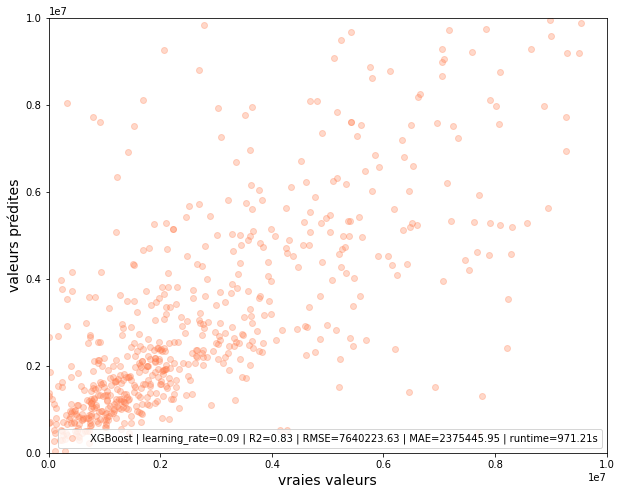

In [48]:
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_xboost,alpha=0.3,color='coral',label= "XGBoost | learning_rate=0.09 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.xlim([0,1e7])
plt.ylim([0,1e7])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 10})

### Support vector regression (SVR) à noyau linéaire (modèle linéaire)

In [49]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

c_range = np.logspace(-2, 2, 6)
gamma_range = np.logspace(-2, 2, 6)
tuned_parameters = [{'kernel': ['linear'], 'C': c_range,'gamma':gamma_range}]

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}

svr = SVR()
grid_svr = model_selection.GridSearchCV(svr,param_grid=tuned_parameters,refit="r2",cv=5,scoring=score)
grid_svr.fit(X_train_std, y_train)
y_pred_svr = grid_svr.predict(X_test_std)
elapsed = timeit.default_timer() - start_time

print("Résultats de la validation croisée de l'algorithme SVR pour:")
for mean_r2, std_r2, params in zip(
        grid_svr.cv_results_['mean_test_r2'], 
        grid_svr.cv_results_['std_test_r2'], 
        grid_svr.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_svr.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_svr.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_svr.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_svr.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_svr.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_svr.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

print("Voici les résultats obtenus avec l'algorithme SVR :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_svr.best_params_)
best_RMSE = min(grid_svr.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_svr.cv_results_['mean_test_r2'])
best_MAE = min(grid_svr.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme SVR sur le jeu de test : {:.2f}s".format(elapsed))   


Résultats de la validation croisée de l'algorithme SVR pour:
r2 = -0.076 (+/-0.026) for {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
r2 = -0.076 (+/-0.026) for {'C': 1.0, 'gamma': 0.0003727593720314938, 'kernel': 'linear'}
r2 = -0.076 (+/-0.026) for {'C': 1.0, 'gamma': 0.0013894954943731374, 'kernel': 'linear'}
r2 = -0.076 (+/-0.026) for {'C': 1.0, 'gamma': 0.005179474679231213, 'kernel': 'linear'}
r2 = -0.076 (+/-0.026) for {'C': 1.0, 'gamma': 0.019306977288832496, 'kernel': 'linear'}
r2 = -0.076 (+/-0.026) for {'C': 1.0, 'gamma': 0.07196856730011514, 'kernel': 'linear'}
r2 = -0.076 (+/-0.026) for {'C': 1.0, 'gamma': 0.2682695795279725, 'kernel': 'linear'}
r2 = -0.076 (+/-0.026) for {'C': 1.0, 'gamma': 1.0, 'kernel': 'linear'}
r2 = -0.075 (+/-0.026) for {'C': 3.72759372031494, 'gamma': 0.0001, 'kernel': 'linear'}
r2 = -0.075 (+/-0.026) for {'C': 3.72759372031494, 'gamma': 0.0003727593720314938, 'kernel': 'linear'}
r2 = -0.075 (+/-0.026) for {'C': 3.72759372031494, 'gamma': 0.001389

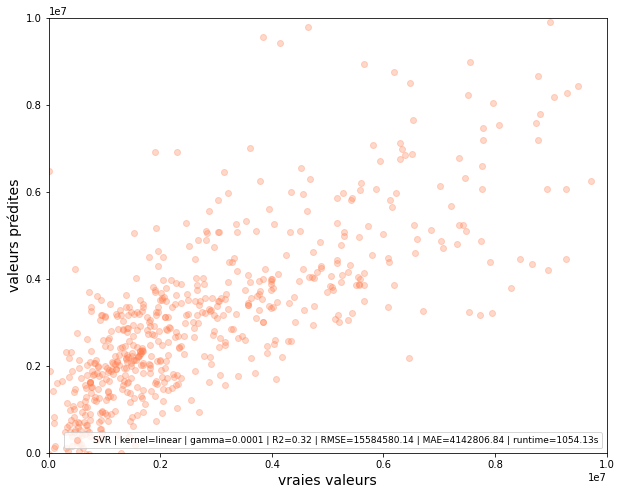

In [50]:
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_svr,alpha=0.3,color='coral',label= "SVR | kernel=linear | gamma=0.0001 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.xlim([0,1e7])
plt.ylim([0,1e7])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 9})

### Support vector regression (SVR) à noyau rbf (modèle non linéaire)

In [68]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

c_range = np.logspace(-2, 2, 6)
gamma_range = np.logspace(-2, 2, 6)
tuned_parameters = [{'kernel': ['rbf'], 'C': c_range,'gamma':gamma_range}]

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}

svr = SVR()
grid_svr = model_selection.GridSearchCV(svr,param_grid=tuned_parameters,refit="r2",cv=5,scoring=score)
grid_svr.fit(X_train_std, y_train)
y_pred_svr = grid_svr.predict(X_test_std)
elapsed = timeit.default_timer() - start_time

print("Résultats de la validation croisée de l'algorithme SVR pour:")
for mean_r2, std_r2, params in zip(
        grid_svr.cv_results_['mean_test_r2'], 
        grid_svr.cv_results_['std_test_r2'], 
        grid_svr.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_svr.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_svr.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_svr.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_svr.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_svr.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_svr.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

print("Voici les résultats obtenus avec l'algorithme SVR :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_svr.best_params_)
best_RMSE = min(grid_svr.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_svr.cv_results_['mean_test_r2'])
best_MAE = min(grid_svr.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme SVR sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme SVR sur le jeu de test : {:.2f}s".format(elapsed))   

Résultats de la validation croisée de l'algorithme SVR pour:
r2 = -0.092 (+/-0.037) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
r2 = -0.092 (+/-0.037) for {'C': 0.01, 'gamma': 0.06309573444801933, 'kernel': 'rbf'}
r2 = -0.092 (+/-0.037) for {'C': 0.01, 'gamma': 0.3981071705534973, 'kernel': 'rbf'}
r2 = -0.092 (+/-0.037) for {'C': 0.01, 'gamma': 2.5118864315095824, 'kernel': 'rbf'}
r2 = -0.092 (+/-0.037) for {'C': 0.01, 'gamma': 15.848931924611142, 'kernel': 'rbf'}
r2 = -0.092 (+/-0.037) for {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'}
r2 = -0.092 (+/-0.037) for {'C': 0.06309573444801933, 'gamma': 0.01, 'kernel': 'rbf'}
r2 = -0.092 (+/-0.037) for {'C': 0.06309573444801933, 'gamma': 0.06309573444801933, 'kernel': 'rbf'}
r2 = -0.092 (+/-0.037) for {'C': 0.06309573444801933, 'gamma': 0.3981071705534973, 'kernel': 'rbf'}
r2 = -0.092 (+/-0.037) for {'C': 0.06309573444801933, 'gamma': 2.5118864315095824, 'kernel': 'rbf'}
r2 = -0.092 (+/-0.037) for {'C': 0.06309573444801933, 'gamma': 15.84

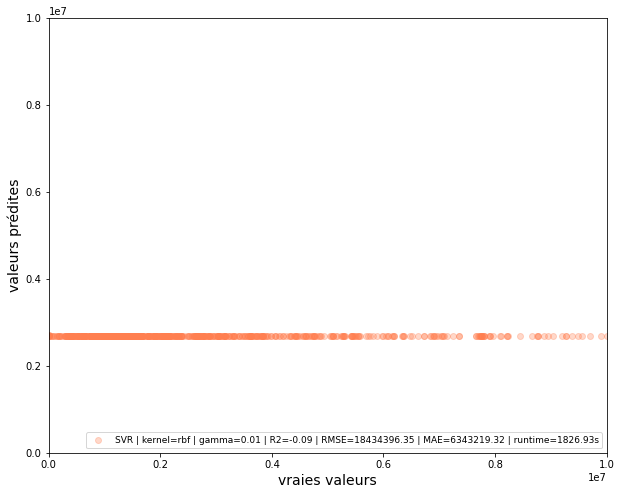

In [69]:
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_svr,alpha=0.3,color='coral',label= "SVR | kernel=rbf | gamma=0.01 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.xlim([0,1e7])
plt.ylim([0,1e7])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 9})

Text(0, 0.5, 'R2')

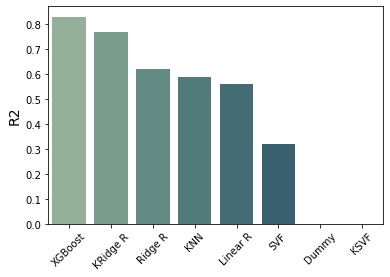

In [70]:
results_R2 = pd.DataFrame(np.array([[0,0.56,0.62,0.77,0.59,0.83,0.32,0]]), columns=["Dummy","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
results_R2=results_R2.sort_values(by=0,ascending=False,axis=1)
results_R2 = results_R2.T
results_R2.columns = ['R2']
sns.barplot(x = results_R2.index,y = results_R2["R2"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("R2",fontsize=14)

Text(0, 0.5, 'RMSE')

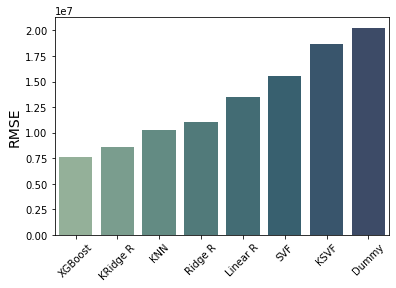

In [71]:
results_RMSE = pd.DataFrame(np.array([[20261762.48,13482354.62,11001443.03,8560903.01,10211297.00,7640223.63,15584580.14,18655465.49]]), columns=["Dummy","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
results_RMSE=results_RMSE.sort_values(by=0,ascending=True,axis=1)
results_RMSE = results_RMSE.T
results_RMSE.columns = ['RMSE']
sns.barplot(x = results_RMSE.index,y = results_RMSE["RMSE"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("RMSE",fontsize=14)

Text(0, 0.5, 'MAE')

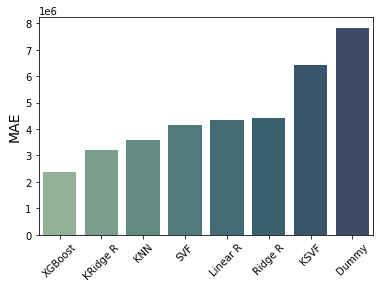

In [72]:
results_MAE = pd.DataFrame(np.array([[7831402.92,4333841.75,4402375.68,3219968.82,3592698.21,2375445.95,4142806.84,6411849.98]]), columns=["Dummy","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
results_MAE=results_MAE.sort_values(by=0,ascending=True,axis=1)
results_MAE = results_MAE.T
results_MAE.columns = ['MAE']
sns.barplot(x = results_MAE.index,y = results_MAE["MAE"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("MAE",fontsize=14)

Text(0, 0.5, 'Runtime')

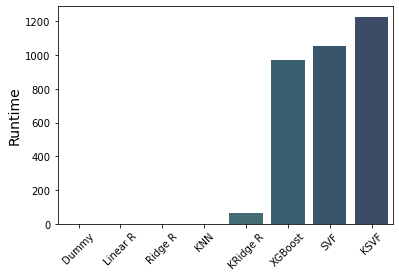

In [73]:
results_runtime = pd.DataFrame(np.array([[0,0,0.11,63.84,0.80,971.21,1054.13,1227.89]]), columns=["Dummy","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
results_runtime=results_runtime.sort_values(by=0,ascending=True,axis=1)
results_runtime = results_runtime.T
results_runtime.columns = ['Runtime']
sns.barplot(x = results_runtime.index,y = results_runtime["Runtime"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Runtime",fontsize=14)

- **Comme pour la préduction de l'émission du carbone, l'algorithme est le meilleur estimateur pour prédire la consommation totale de l'énergie au niveau de tout les métriques évalués.**

## ENERGYSTARScore evaluation

### Régression

Les meilleurs paramètres de l'algorithme XGBoost sont {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Résultats de la validation croisée de le boost gradient pour:
r2 = 0.625 (+/-0.065) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.554 (+/-0.062) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
r2 = 0.462 (+/-0.079) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.1}
r2 = 0.715 (+/-0.099) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
r2 = 0.662 (+/-0.074) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
r2 = 0.589 (+/-0.053) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.1}
r2 = 0.653 (+/-0.037) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.599 (+/-0.042) for {'learning_rate': 0.01, 'max_depth': 5, 'n_e

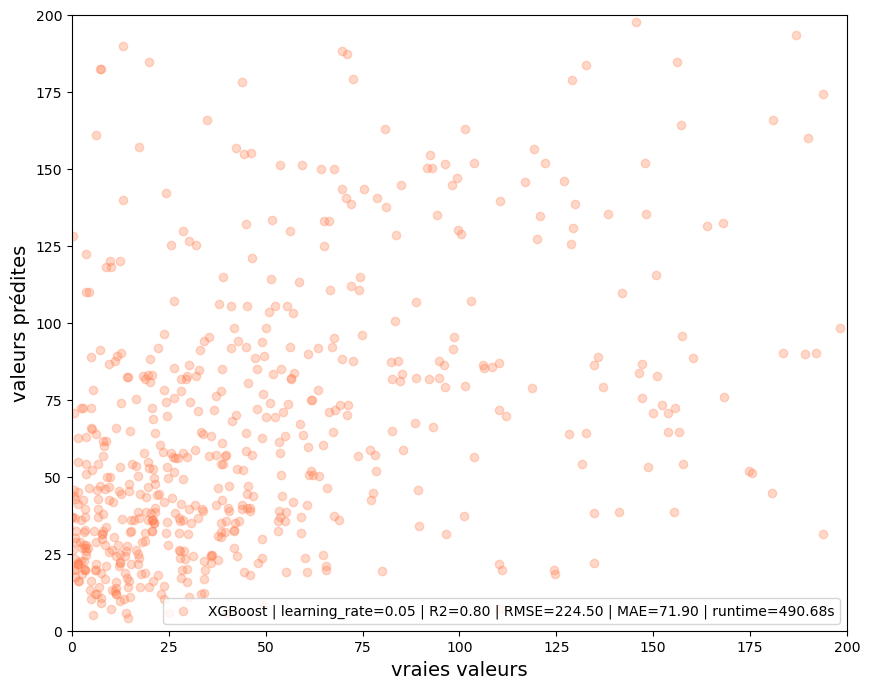

In [470]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)","ENERGYSTARScore"],axis=1)
y = data_encod["TotalGHGEmissions"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)


subsample = [0.9,0.5,0.1]
n_estimators = [100,200]
max_depth = [3,5,8,10]
learning_range = np.arange(0.01,0.11,0.01)

param_grid = {'max_depth':max_depth,'learning_rate':learning_range,'subsample':subsample,'n_estimators':n_estimators}

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}


start_time = timeit.default_timer()
grid_pred_xboost = model_selection.GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_xboost.fit(X_train_std, y_train)

y_pred_xboost = grid_pred_xboost.predict(X_test_std)

elapsed = timeit.default_timer() - start_time

print ("Les meilleurs paramètres de l'algorithme XGBoost sont",grid_pred_xboost.best_params_)
print("Résultats de la validation croisée de le boost gradient pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_xboost.cv_results_['mean_test_r2'], 
        grid_pred_xboost.cv_results_['std_test_r2'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_xboost.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_xboost.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

best_RMSE = min(grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_xboost.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'])

fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_xboost,alpha=0.3,color='coral',label= "XGBoost | learning_rate=0.05 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.xlim([0,200])
plt.ylim([0,200])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 10})

In [471]:
print("Voici les résultats obtenus avec l'algorithme gradient boost Regression :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_xboost.best_params_)
print("Le meilleur coefficient de détermination R2 de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}s".format(elapsed))

Voici les résultats obtenus avec l'algorithme gradient boost Regression :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Le meilleur coefficient de détermination R2 de l'algorithme Gradient Boosting Regression sur le jeu de test : 0.80
Le meilleur RMSE de l'algorithme Gradient Boosting Regression sur le jeu de test : 224.50
Le meilleur MAE de l'algorithme Gradient Boosting Regression sur le jeu de test : 71.90
Le temps d'execution de l'algorithme Gradient Boosting Regression sur le jeu de test : 490.68s


Les meilleurs paramètres de l'algorithme XGBoost sont {'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.5}
Résultats de la validation croisée de le boost gradient pour:
r2 = 0.619 (+/-0.127) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.611 (+/-0.093) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
r2 = 0.502 (+/-0.046) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.1}
r2 = 0.697 (+/-0.158) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
r2 = 0.713 (+/-0.114) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
r2 = 0.629 (+/-0.056) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.1}
r2 = 0.647 (+/-0.117) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.646 (+/-0.081) for {'learning_rate': 0.01, 'max_depth': 5, 'n_

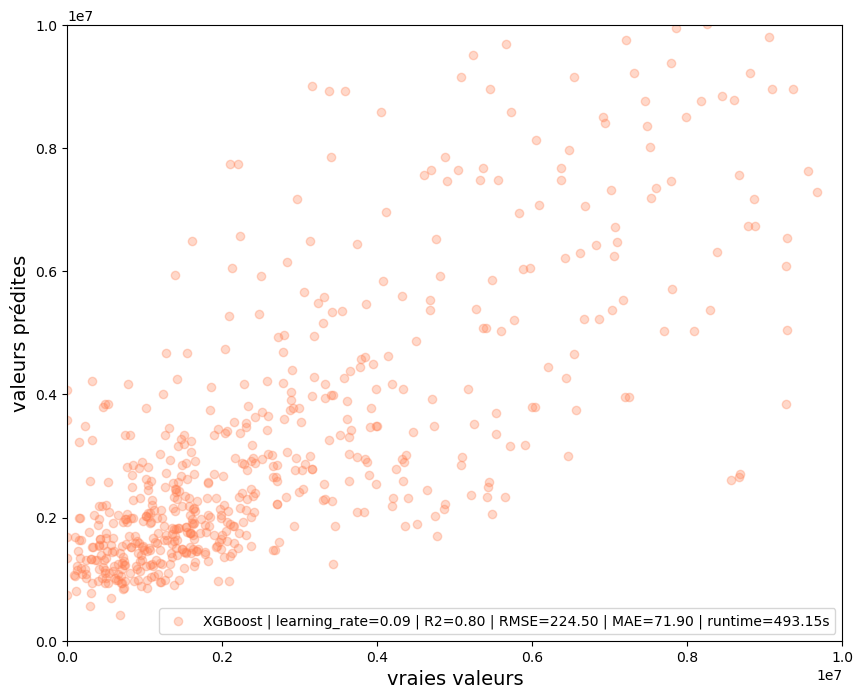

In [472]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)","ENERGYSTARScore"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

subsample = [0.9,0.5,0.1]
n_estimators = [100,200]
max_depth = [3,5,8,10]
learning_range = np.arange(0.01,0.11,0.01)

param_grid = {'max_depth':max_depth,'learning_rate':learning_range,'subsample':subsample,'n_estimators':n_estimators}


start_time = timeit.default_timer()
grid_pred_xboost = model_selection.GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_xboost.fit(X_train_std, y_train)

y_pred_xboost = grid_pred_xboost.predict(X_test_std)

elapsed = timeit.default_timer() - start_time

print ("Les meilleurs paramètres de l'algorithme XGBoost sont",grid_pred_xboost.best_params_)
print("Résultats de la validation croisée de le boost gradient pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_xboost.cv_results_['mean_test_r2'], 
        grid_pred_xboost.cv_results_['std_test_r2'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_xboost.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_xboost.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))
    
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_xboost,alpha=0.3,color='coral',label= "XGBoost | learning_rate=0.09 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2,best_RMSE,best_MAE,elapsed))
plt.xlim([0,1e7])
plt.ylim([0,1e7])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 10})

In [473]:
print("Voici les résultats obtenus avec l'algorithme gradient boost Regression :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_xboost.best_params_)
best_RMSE = min(grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_xboost.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}".format(best_MAE))
print("Le temps d'execution de l'algorithme Gradient Boosting Regression sur le jeu de test : {:.2f}s".format(elapsed))

Voici les résultats obtenus avec l'algorithme gradient boost Regression :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.5}
Le meilleur coefficient de détermination R2 de l'algorithme Gradient Boosting Regression sur le jeu de test : 0.80
Le meilleur RMSE de l'algorithme Gradient Boosting Regression sur le jeu de test : 8177355.29
Le meilleur MAE de l'algorithme Gradient Boosting Regression sur le jeu de test : 2537106.07
Le temps d'execution de l'algorithme Gradient Boosting Regression sur le jeu de test : 493.15s


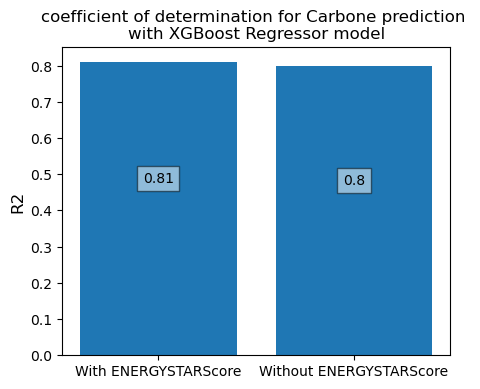

In [522]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/1.7,y[i], ha = 'center',
                 bbox = dict(facecolor = 'white', alpha = .5))
        
if __name__ == '__main__':
    
    x = ["With ENERGYSTARScore","Without ENERGYSTARScore"]
    y = [0.81,0.80]
      
    plt.figure(figsize = (5,4))
    plt.bar(x, y)
      
    addlabels(x, y)
      
    plt.title("coefficient of determination for Carbone prediction \nwith XGBoost Regressor model")
      
    plt.ylabel("R2",fontsize=12)      
    plt.show()

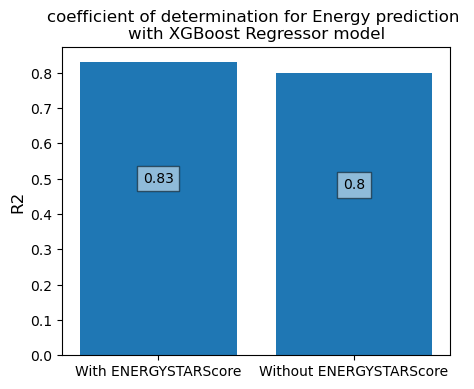

In [523]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/1.7,y[i], ha = 'center',
                 bbox = dict(facecolor = 'white', alpha = .5))
        
if __name__ == '__main__':
    
    x = ["With ENERGYSTARScore","Without ENERGYSTARScore"]
    y = [0.83,0.80]
      
    plt.figure(figsize = (5,4))
    plt.bar(x, y)
      
    addlabels(x, y)
      
    plt.title("coefficient of determination for Energy prediction \nwith XGBoost Regressor model")
      
    plt.ylabel("R2",fontsize=12)      
    plt.show()

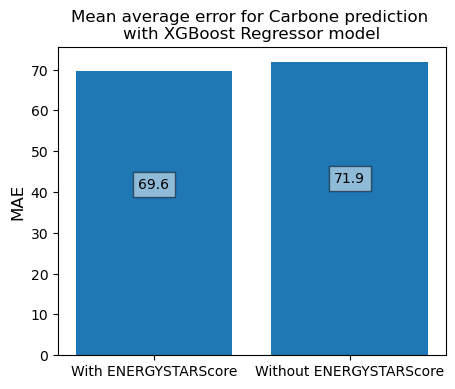

In [525]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/1.7,y[i], ha = 'center',
                 bbox = dict(facecolor = 'white', alpha = .5))
        
if __name__ == '__main__':
    
    x = ["With ENERGYSTARScore","Without ENERGYSTARScore"]
    y = [69.60,71.90]
      
    plt.figure(figsize = (5,4))
    plt.bar(x, y)
      
    addlabels(x, y)
      
    plt.title("Mean average error for Carbone prediction \nwith XGBoost Regressor model")
      
    plt.ylabel("MAE",fontsize=12)      
    plt.show()

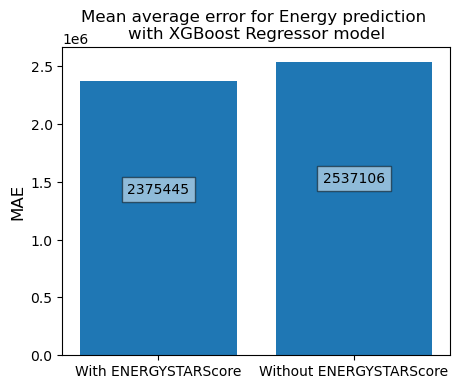

In [526]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/1.7,y[i], ha = 'center',
                 bbox = dict(facecolor = 'white', alpha = .5))
        
if __name__ == '__main__':
    
    x = ["With ENERGYSTARScore","Without ENERGYSTARScore"]
    y = [2375445,2537106]
      
    plt.figure(figsize = (5,4))
    plt.bar(x, y)
      
    addlabels(x, y)
      
    plt.title("Mean average error for Energy prediction \nwith XGBoost Regressor model")
      
    plt.ylabel("MAE",fontsize=12)      
    plt.show()

- On conclue que l'ENERGYSTARScore permet de construire un modèle plus performant pour les prédictions. 

## Classification

- Je vais maintenant essayer de traiter le problème comme un problème de classification au lieu d'un problème de régression, pour cela je vais diviser les valeurs de consommation et d'émissions en 3 catégories : 0:Low , 1:MED et 2:HIGH. Cette répartition est effectuée à l'aide des valeurs du 1er et du 3eme quartile.

In [77]:
data_encod[["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"]].describe()

,TotalGHGEmissions,SiteEnergyUseWN(kBtu)
count,3048.000000,3.048000e+03
mean,164.325997,7.763053e+06
std,566.067756,1.882415e+07
min,-0.800000,0.000000e+00
25%,18.997500,1.281681e+06
50%,47.595000,2.713462e+06
75%,135.552500,7.195354e+06
max,12307.160000,2.977410e+08


In [340]:
conditionlist = [(data_encod['TotalGHGEmissions'] < 18.99),(data_encod['TotalGHGEmissions'] >= 18.99) & 
                 (data_encod['TotalGHGEmissions'] < 135.55),(data_encod['TotalGHGEmissions'] >= 135.55)] 
choicelist = ["Low","Medium","High"]
data_encod["TotalGHGEmissions_Class"]=np.select(conditionlist, choicelist, default='Not Specified')

conditionlist = [(data_encod['SiteEnergyUseWN(kBtu)'] < 1.281681e+06),(data_encod['SiteEnergyUseWN(kBtu)'] >= 1.281681e+06) & 
                 (data_encod['SiteEnergyUseWN(kBtu)'] < 7.195354e+06),(data_encod['SiteEnergyUseWN(kBtu)'] >= 7.195354e+06)] 
choicelist = ["Low","Medium","High"]
data_encod["SiteEnergyUseWN(kBtu)_Class"]=np.select(conditionlist, choicelist, default='Not Specified')

In [428]:
data_encod.head(3)

,"(PrimaryPropertyType_Distribution Center,)","(PrimaryPropertyType_Hospital,)","(PrimaryPropertyType_Hotel,)","(PrimaryPropertyType_Laboratory,)","(PrimaryPropertyType_Low-Rise Multifamily,)","(PrimaryPropertyType_Mixed Use Property,)","(PrimaryPropertyType_Office,)","(PrimaryPropertyType_Other,)","(PrimaryPropertyType_Residence Hall/Dormitory,)","(PrimaryPropertyType_Restaurant,)",...,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ZipCode,TotalGHGEmissions,SiteEnergyUseWN(kBtu),ENERGYSTARScore,TotalGHGEmissions_Class,SiteEnergyUseWN(kBtu)_Class
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,12,88434.0,98101,249.43,7097539.0,65.0,High,Medium
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,1,11,103566.0,98101,263.51,8765788.0,51.0,High,High
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,1,41,961990.0,98101,2061.48,75506272.0,18.0,High,High


Text(0.5, 1.0, 'Occurence des classes TotalGHGEmissions ')

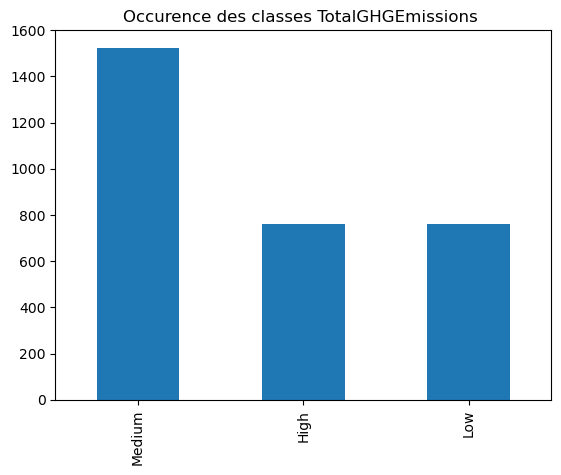

In [429]:
count_TotalGHGEmissions_Class = data_encod["TotalGHGEmissions_Class"].value_counts()
count_TotalGHGEmissions_Class.sort_values(ascending=False).plot.bar()
plt.title("Occurence des classes TotalGHGEmissions ")

Text(0.5, 1.0, 'Occurence des classes SiteEnergyUseWN')

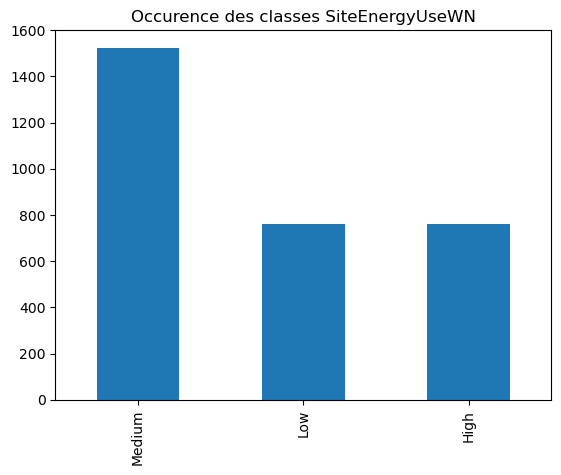

In [430]:
count_SiteEnergyUseWN_Class = data_encod["SiteEnergyUseWN(kBtu)_Class"].value_counts()
count_SiteEnergyUseWN_Class.sort_values(ascending=False).plot.bar()
plt.title("Occurence des classes SiteEnergyUseWN")

- Maintenant je vais évaluer l'ENERGYSTARScore : 

In [431]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)","TotalGHGEmissions_Class","SiteEnergyUseWN(kBtu)_Class"],axis=1)
y = data_encod["TotalGHGEmissions_Class"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

class_pred_xboost = GradientBoostingClassifier(random_state=42,learning_rate=0.08,max_depth=10,n_estimators= 200,subsample= 0.5)
                                    
class_pred_xboost.fit(X_train_std, y_train)

y_pred_xboost = class_pred_xboost.predict(X_test_std)

In [432]:
print("L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = {0:.2f}".format(roc_auc_score(y_test, class_pred_xboost.predict_proba(X_test_std),multi_class='ovr')))

L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = 0.93


Text(0.5, 1.0, "Matrice de confusion de la prédiction de \nl'émission de carbone avec ENERGYSTARScore")

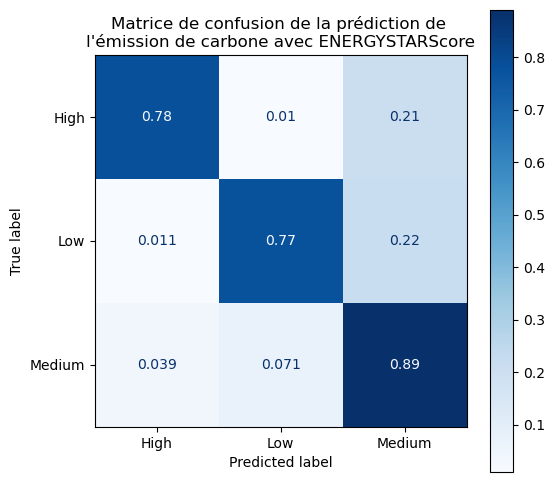

In [433]:
fig, ax = plt.subplots(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_xboost, labels=class_pred_xboost.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_pred_xboost.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax)
disp.ax_.set_title("Matrice de confusion de la prédiction de \nl'émission de carbone avec ENERGYSTARScore")

In [434]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)","TotalGHGEmissions_Class","SiteEnergyUseWN(kBtu)_Class"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)_Class"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

class_pred_xboost = GradientBoostingClassifier(random_state=42,learning_rate=0.08,max_depth=10,n_estimators= 200,subsample= 0.5)

                                    
class_pred_xboost.fit(X_train_std, y_train)

y_pred_xboost = class_pred_xboost.predict(X_test_std)


In [435]:
print("L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = {0:.2f}".format(roc_auc_score(y_test, class_pred_xboost.predict_proba(X_test_std),multi_class='ovr')))

L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = 0.96


Text(0.5, 1.0, "Matrice de confusion de la prédiction de la \nconsommation d'énergie avec ENERGYSTARScore")

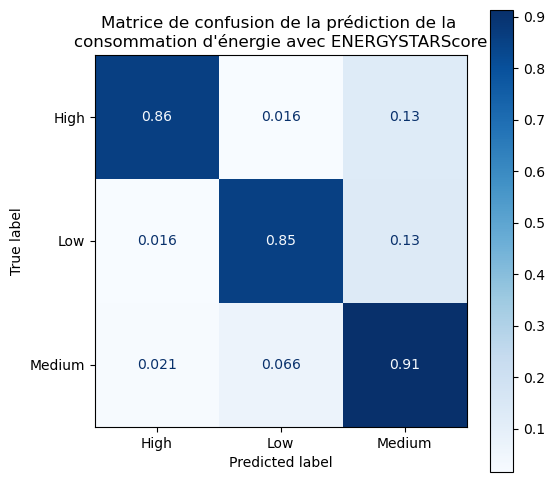

In [436]:
fig, ax = plt.subplots(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_xboost, labels=class_pred_xboost.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_pred_xboost.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax)
disp.ax_.set_title("Matrice de confusion de la prédiction de la \nconsommation d'énergie avec ENERGYSTARScore")

In [437]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)","TotalGHGEmissions_Class","SiteEnergyUseWN(kBtu)_Class","ENERGYSTARScore"],axis=1)
y = data_encod["TotalGHGEmissions_Class"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

class_pred_xboost = GradientBoostingClassifier(random_state=42,learning_rate=0.08,max_depth=10,n_estimators= 200,subsample= 0.5)

                                    
class_pred_xboost.fit(X_train_std, y_train)

y_pred_xboost = class_pred_xboost.predict(X_test_std)

In [438]:
print("L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = {0:.2f}".format(roc_auc_score(y_test, class_pred_xboost.predict_proba(X_test_std),multi_class='ovr')))

L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = 0.92


Text(0.5, 1.0, "Matrice de confusion de la prédiction de \nl'émission de carbone sans ENERGYSTARScore")

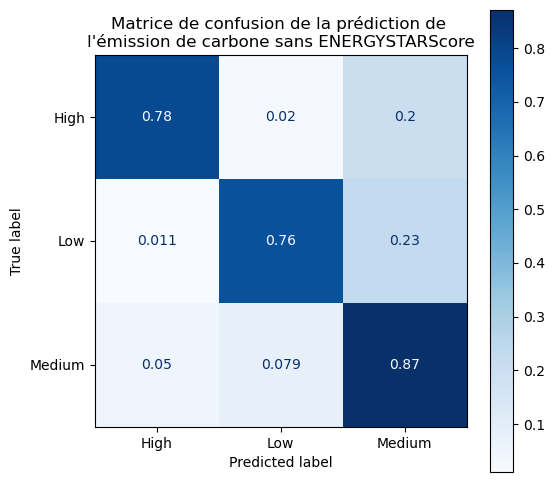

In [439]:
fig, ax = plt.subplots(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_xboost, labels=class_pred_xboost.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_pred_xboost.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax)
disp.ax_.set_title("Matrice de confusion de la prédiction de \nl'émission de carbone sans ENERGYSTARScore")

In [440]:
X = data_encod.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)","TotalGHGEmissions_Class","SiteEnergyUseWN(kBtu)_Class","ENERGYSTARScore"],axis=1)
y = data_encod["SiteEnergyUseWN(kBtu)_Class"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

class_pred_xboost = GradientBoostingClassifier(random_state=42,learning_rate=0.08,max_depth=10,n_estimators= 200,subsample= 0.5)

                                    
class_pred_xboost.fit(X_train_std, y_train)

y_pred_xboost = class_pred_xboost.predict(X_test_std)

In [441]:
print("L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = {0:.2f}".format(roc_auc_score(y_test, class_pred_xboost.predict_proba(X_test_std),multi_class='ovr')))

L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = 0.94


Text(0.5, 1.0, "Matrice de confusion de la prédiction de la \nconsommation d'énergie sans ENERGYSTARScore")

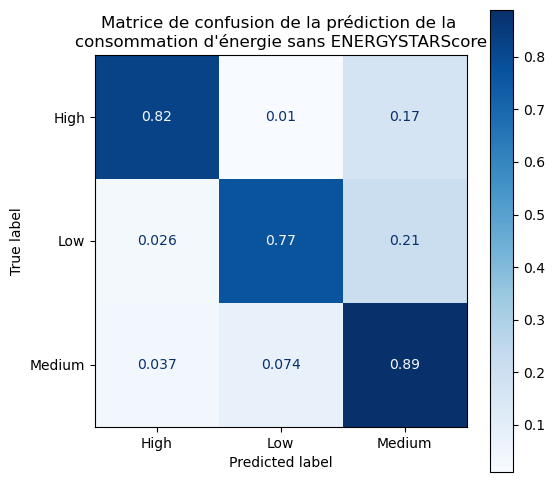

In [442]:
fig, ax = plt.subplots(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_xboost, labels=class_pred_xboost.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_pred_xboost.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax)
disp.ax_.set_title("Matrice de confusion de la prédiction de la \nconsommation d'énergie sans ENERGYSTARScore")

### -ENERGYSTARScore permet une meilleure prédiction de la consommation d'énergie et les émissions de carbone.

Nous allons évaluer maintenant d'autres variables sur l'efficacité de la prédiction.
- On remarque que la variable Neighborhood n'est pas très importante dans les résultats du degré d'impurteté du ForestRegressor, je vais essayer de tester la performance du modèle sans cette variable :

In [443]:
le = LabelEncoder()
ohe = OneHotEncoder(categories='auto')
C1_2 = ohe.fit_transform(data_pred_final[["PrimaryPropertyType"]]).toarray()
ohe_columns = ohe.get_feature_names_out(['PrimaryPropertyType']).astype(str)
C1_2 = pd.DataFrame(C1, columns=[ohe_columns])
C2_2 = data_pred_final[["YearBuilt"]].apply(le.fit_transform)

In [444]:
data_encod_2 = pd.concat([C1_2,C2_2,data_pred_final.drop(["PrimaryPropertyType","Neighborhood","YearBuilt"],axis=1)],axis=1)

In [445]:
conditionlist = [(data_encod_2['TotalGHGEmissions'] < 18.99),(data_encod_2['TotalGHGEmissions'] >= 18.99) & 
                 (data_encod_2['TotalGHGEmissions'] < 135.55),(data_encod_2['TotalGHGEmissions'] >= 135.55)] 
choicelist = ["Low","Medium","High"]
data_encod_2["TotalGHGEmissions_Class"]=np.select(conditionlist, choicelist, default='Not Specified')

conditionlist = [(data_encod_2['SiteEnergyUseWN(kBtu)'] < 1.281681e+06),(data_encod_2['SiteEnergyUseWN(kBtu)'] >= 1.281681e+06) & 
                 (data_encod_2['SiteEnergyUseWN(kBtu)'] < 7.195354e+06),(data_encod_2['SiteEnergyUseWN(kBtu)'] >= 7.195354e+06)] 
choicelist = ["Low","Medium","High"]
data_encod_2["SiteEnergyUseWN(kBtu)_Class"]=np.select(conditionlist, choicelist, default='Not Specified')

In [446]:
X = data_encod_2.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)","TotalGHGEmissions_Class","SiteEnergyUseWN(kBtu)_Class"],axis=1)
y = data_encod_2["TotalGHGEmissions_Class"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

class_pred_xboost = GradientBoostingClassifier(random_state=42,learning_rate=0.08,max_depth=10,n_estimators= 200,subsample= 0.5)
                                    
class_pred_xboost.fit(X_train_std, y_train)

y_pred_xboost = class_pred_xboost.predict(X_test_std)

In [447]:
print("L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = {0:.2f}".format(roc_auc_score(y_test, class_pred_xboost.predict_proba(X_test_std),multi_class='ovr')))

L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = 0.93


Text(0.5, 1.0, "Matrice de confusion de la prédiction de \nl'émission de carbone avec ENERGYSTARScore \net sans Neighborhood")

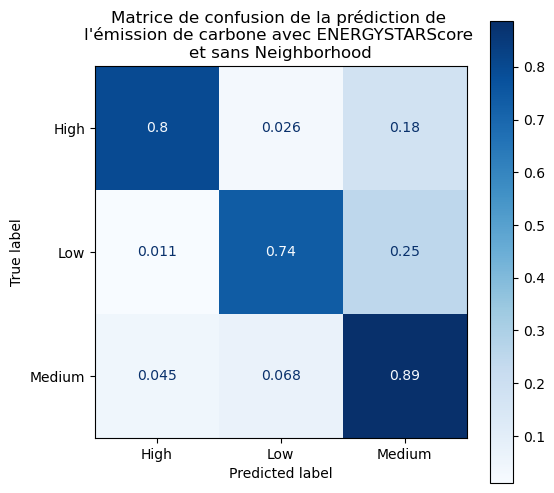

In [448]:
fig, ax = plt.subplots(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_xboost, labels=class_pred_xboost.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_pred_xboost.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax)
disp.ax_.set_title("Matrice de confusion de la prédiction de \nl'émission de carbone avec ENERGYSTARScore \net sans Neighborhood")

In [449]:
X = data_encod_2.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)","TotalGHGEmissions_Class","SiteEnergyUseWN(kBtu)_Class"],axis=1)
y = data_encod_2["SiteEnergyUseWN(kBtu)_Class"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

class_pred_xboost = GradientBoostingClassifier(random_state=42,learning_rate=0.08,max_depth=10,n_estimators= 200,subsample= 0.5)

                                    
class_pred_xboost.fit(X_train_std, y_train)

y_pred_xboost = class_pred_xboost.predict(X_test_std)

In [450]:
print("L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = {0:.2f}".format(roc_auc_score(y_test, class_pred_xboost.predict_proba(X_test_std),multi_class='ovr')))

L'aire sous la courbe caractéristique d'Opération (ROC) qui mesure la précision de prédiction du modèle = 0.96


Text(0.5, 1.0, "Matrice de confusion de la prédiction de la \nconsommation d'énergie avec ENERGYSTARScore \net sans Neighborhood")

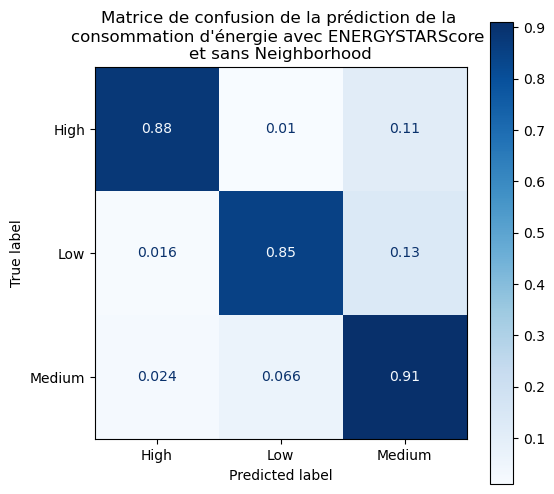

In [451]:
fig, ax = plt.subplots(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_xboost, labels=class_pred_xboost.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_pred_xboost.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax)
disp.ax_.set_title("Matrice de confusion de la prédiction de la \nconsommation d'énergie avec ENERGYSTARScore \net sans Neighborhood")

- On conclue que le modèle est plus performant avec l'ENERGYSTARScore et sans le Neighborhood.